In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from tools.e5tools import *
from orographicConvectionTheory.orographicConvectionTheory import linear_precip_theory,nonlinear_precip_theory
km_per_degreelat = 6370*np.pi/180
mnths=['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']


import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units

import itertools

from scipy.stats import linregress

In [2]:
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81

In [3]:
mountains=         {"vietnam"    :([102,115,10,19.5],"Annamite range (Vietnam)",240,10),
                    "ghats"      :([68,80,7.5,17]   ,"Western Ghats"           ,70 ,6 ),
                    "madagascar" :([40,60,-25,-12]  ,"Madagascar"              ,280,3 ),
                    "myanmar"    :([80,102,7,27]    ,"Myanmar"                 ,60 ,7 ),
                    "newbritain" :([148,155,-12,0]  ,"New Britain"             ,320,7 ),
                    "philippines":([118,130,10,22]  ,"Philippines"             ,225,12),
                    "sumatra"    :([90,110,-6,6]    ,"Bukit Barisan (Sumatra)" ,70 ,11),
                    "malaysia"   :([97,107,1,10]    ,"Malaysia"                ,225,11),
                   }

precip_boxes = {"vietnam"    :[107  ,  19  , 110.5, 14   ,2  ],
                "ghats"      :[ 75  ,   9  ,  72.5, 16   ,2  ],
                "madagascar" :[ 52  , -14.5,  49  , -24.5,2.5],
                "myanmar"    :[ 98  ,  11  ,  90  , 21   ,4  ],
                "newbritain" :[154  , - 6  , 150  , -8   ,2  ],
                "philippines":[123.5,  19  , 127  , 11   ,3  ],
                "sumatra"    :[ 98.5, - 2  ,  96  , 2    ,2.5],
                "malaysia"   :[100.5,  10  , 105  , 4    ,2  ],
               }

In [4]:
def tilted_rect(grid,x1,y1,x2,y2,width,reverse=False):
    x = grid.longitude
    y = grid.latitude
    if reverse:
        halfplane_para = (x-x1)*(y2-y1) - (x2-x1)*(y-y1) <=0
    else:
        halfplane_para = (x-x1)*(y2-y1) - (x2-x1)*(y-y1) >=0
    sc_prod = (x-x1)*(x2-x1)+(y-y1)*(y2-y1)
    halfplane_perp_up = sc_prod >= 0
    halfplane_perp_dn = (x-x2)*(x1-x2)+(y-y2)*(y1-y2) >= 0
    distance_across = np.sqrt((x-x1)**2+(y-y1)**2 - sc_prod**2/((x2-x1)**2+(y2-y1)**2))
    return (halfplane_para*halfplane_perp_up*halfplane_perp_dn*(distance_across<width)).transpose('latitude','longitude')
def crossslopeflow(u,v,angle):
    return (u*np.sin(angle*np.pi/180)+v*np.cos(angle*np.pi/180))
    

In [5]:
def get_bins(var,nbins):
    var_sorted = sorted(np.array(var).reshape(-1))
    quantiles=np.linspace(0.,len(var)-1,nbins+1)
    bins = [var_sorted[int(i)]  for i in quantiles]
    bin_centers = [np.mean(var_sorted[int(quantiles[i]):int(quantiles[i+1])]) for i in range(len(quantiles)-1)]
    return np.array(bins)#,np.array(bin_centers)

def get_binned(a,b,bins):
    bins=bins[(bins>float(a.min()))&(bins<float(a.max()))]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    return bin_centers,bin_means
def get_count(a,bins):
    bins=bins[(bins>float(a.min()))&(bins<float(a.max()))]
    bin_centers=(bins[1:]+bins[:-1])/2
    count = np.histogram(a,bins)[0]
    return bin_centers,count

# Data loading

In [6]:
%%time
trmmpr=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr.rename({'lat':'latitude','lon':'longitude'})
trmmpr = trmmpr.reindex(latitude=list(reversed(trmmpr.latitude)))
#trmmpr_seasmean = 86400*trmmpr.groupby("time.month").mean("time")
#trmmpr_inmean = 86400*trmmpr.sel(time=slice("2000-06-01","2014-01-01")).groupby("time.month").mean("time")
trmmpr_inmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/TRMM-seasonalmean-20006-201312.nc")

CPU times: user 78.8 ms, sys: 17.9 ms, total: 96.7 ms
Wall time: 1.4 s


In [7]:
%%time
gpm_pr=xr.open_mfdataset("/global/cfs/projectdirs/m3310/qnicolas/GPM-IMERG/*.nc").precipitation.rename({'lat':'latitude','lon':'longitude'})
gpm_pr.coords['longitude'] = gpm_pr.coords['longitude'] % 360
gpm_pr = gpm_pr.sortby(gpm_pr.longitude)
gpm_pr = gpm_pr.reindex(latitude=list(reversed(gpm_pr.latitude)))
#gpm_pr_seasmean = gpm_pr.groupby("time.month").mean("time")
#gpm_pr_inmean = gpm_pr.sel(time=slice("2000-06-01","2014-01-01")).groupby("time.month").mean("time").load()
#gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean.nc")
gpm_pr_inmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-20006-201312.nc")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


CPU times: user 594 ms, sys: 4.18 ms, total: 599 ms
Wall time: 2.29 s


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [8]:
era5pr = 1000*e5_climatology('128_228_tp', years=range(2009,2019))
era5100u =    e5_climatology("*_100u",     years=range(2009,2019))
era5100v =    e5_climatology("*_100v",     years=range(2009,2019))

3.4594264030456543
3.4829916954040527
3.747044801712036


In [9]:
era5cape = e5_climatology('*_cape', years=range(2009,2019))
era5cin = e5_climatology('*_cin', years=range(2009,2019))

2.8665008544921875
2.0969419479370117


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [10]:
era5u=xr.open_dataarray("/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_131_u.ll025sc.2009-2018.mean.nc")
era5v=xr.open_dataarray("/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_132_v.ll025sc.2009-2018.mean.nc")
era5t=xr.open_dataarray("/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_130_t.ll025sc.2009-2018.mean.nc")
era5q=xr.open_dataarray("/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_133_q.ll025sc.2009-2018.mean.nc")

# Pr maps

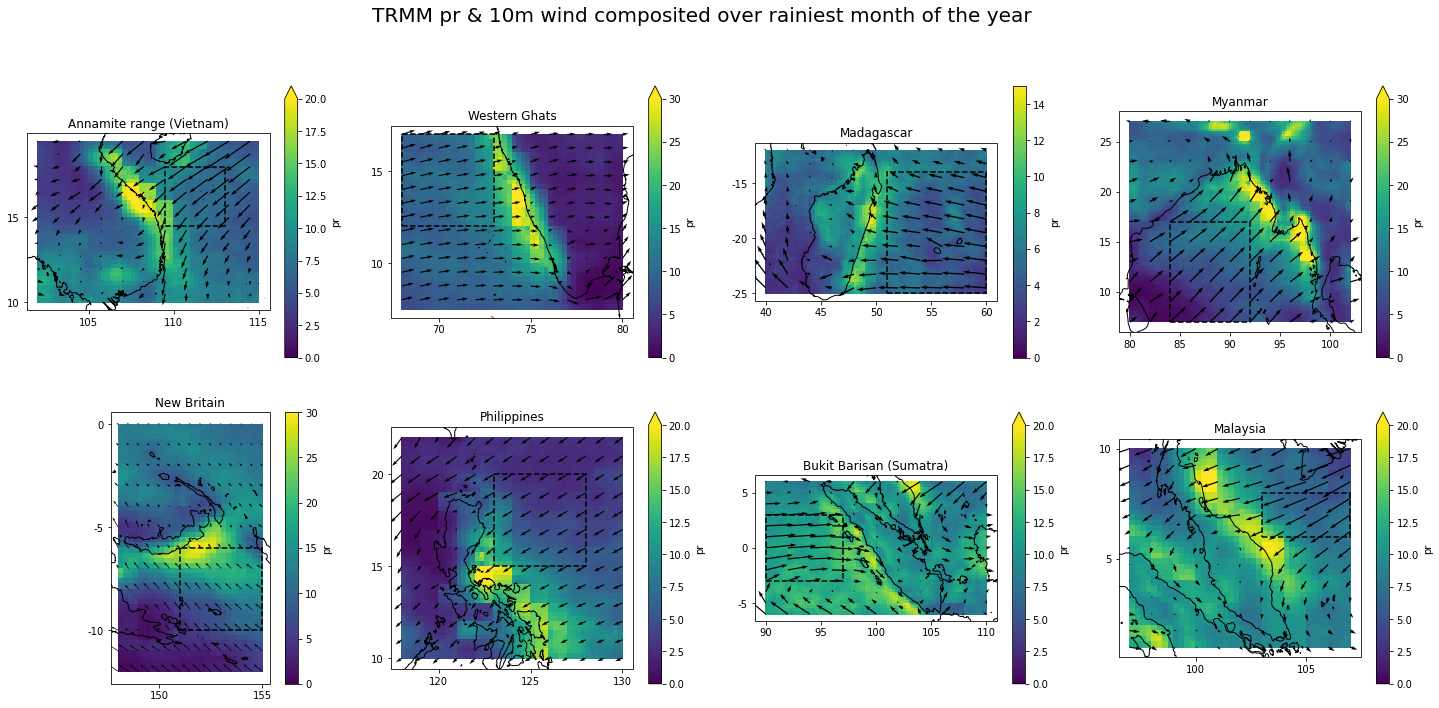

In [34]:
fig,ax = plt.subplots(2,4,figsize=(25,11),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)
vmaxs=[20,30,15,30,30,20,20,20]
for i,name in enumerate(mountains):
    box,Lname,_,mnth = mountains[name]
    ax[i].coastlines()
    window=trmmpr_inmean.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]),month=mountains[name][3])
    window.plot(ax=ax[i],transform=ccrs.PlateCarree(),vmin=0.,vmax=vmaxs[i])
    ax[i].set_title(Lname)
    
    u=era5100u.sel(month=mnth,longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    v=era5100v.sel(month=mnth,longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//10
    m=len(u.longitude)//10
    ax[i].quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree())
    
    #Boxes
    smallbox = mountains_upstream[name]
    ax[i].add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                       edgecolor='k',
                                       fill = False,
                                       lw=1.5,
                                       linestyle='--',
                                       transform=ccrs.PlateCarree())
                    )
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax[i].set_xticks(lons)
    ax[i].set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax[i].set_yticks(lats)
    ax[i].set_yticklabels(lats)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    
fig.suptitle("TRMM pr & 10m wind composited over rainiest month of the year",fontsize=20);None

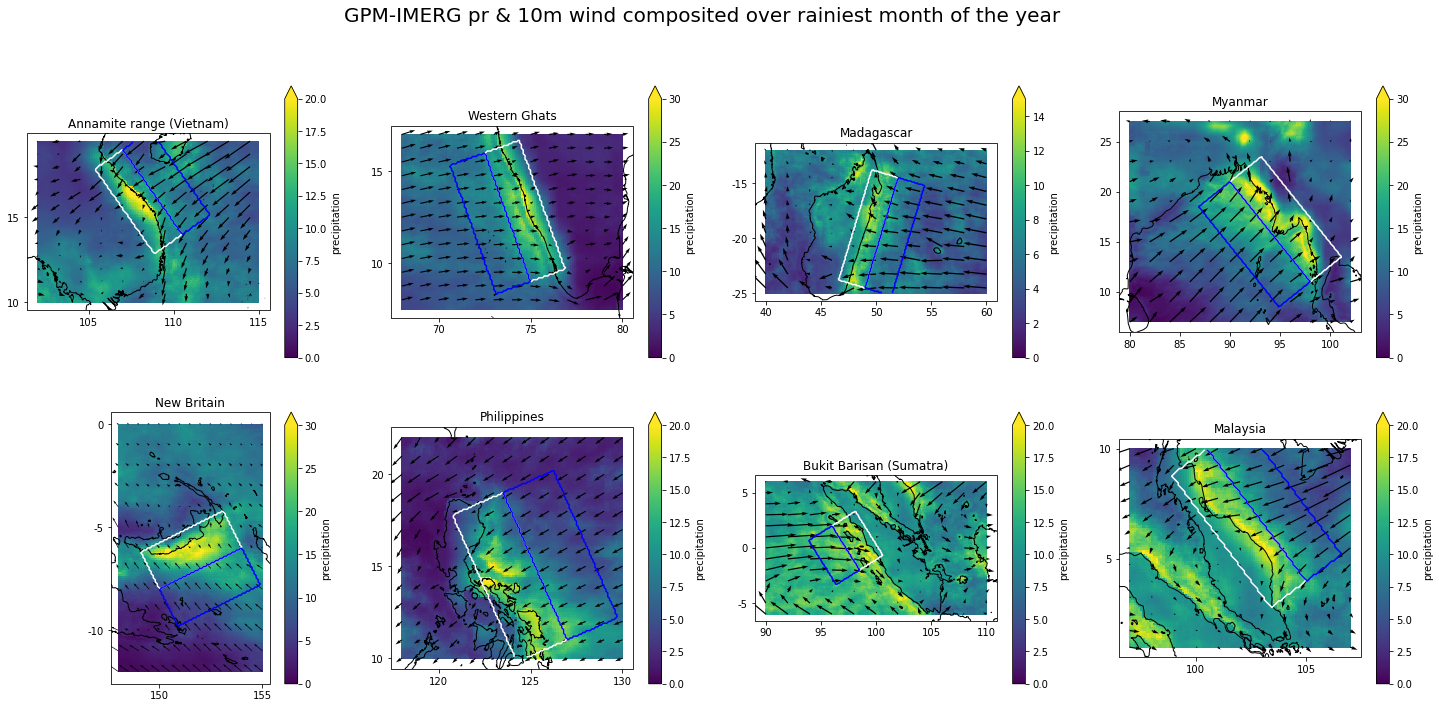

In [49]:
fig,ax = plt.subplots(2,4,figsize=(25,11),subplot_kw={"projection":ccrs.PlateCarree()})
ax = ax.reshape(-1)
vmaxs=[20,30,15,30,30,20,20,20]
for i,name in enumerate(mountains):
    box,Lname,_,mnth = mountains[name]
    ax[i].coastlines()
    window=gpm_pr_inmean.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]),month=mountains[name][3])
    window.plot(ax=ax[i],transform=ccrs.PlateCarree(),vmin=0.,vmax=vmaxs[i])
    
    tilted_rect(window,*precip_boxes[name]).plot.contour(ax=ax[i],levels=[0.5],colors='w')
    tilted_rect(window,*precip_boxes[name],reverse=True).plot.contour(ax=ax[i],levels=[0.5],colors='b')
                   
    u=era5100u.sel(month=mnth,longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    v=era5100v.sel(month=mnth,longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//10
    m=len(u.longitude)//10
    ax[i].quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree())
    
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    ax[i].set_xticks(lons)
    ax[i].set_xticklabels(lons)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    ax[i].set_yticks(lats)
    ax[i].set_yticklabels(lats)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_title(Lname)
    
fig.suptitle("GPM-IMERG pr & 10m wind composited over rainiest month of the year",fontsize=20);None

# Wind-pr correlation

In [55]:
def get_crossslopeu(box,angle,year,mnth):
    """Computes rotated means of a given variable"""
    u100mean = xr.open_dataset(e5_monthly_file('228_246_100u',year)).VAR_100U.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))[mnth-1]
    v100mean = xr.open_dataset(e5_monthly_file('228_247_100v',year)).VAR_100V.sel(longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))[mnth-1]
    return crossslopeflow(u100mean,v100mean,angle)


In [61]:
%%time
gpmyears=range(2001,2019)
umeans={name : [] for name in mountains}
prmeans={name : [] for name in mountains}
for name in mountains:
    print('')
    print(name,end=' ')
    box,_,angle,mnth = mountains[name]
    for year in gpmyears:
        print(year,end=' ')
        window = get_crossslopeu(box,angle,year,mnth)
        masku = tilted_rect(window,*precip_boxes[name],reverse=True)
        umeans[name].append(float(spatial_mean(window,mask=masku).load()))
        window = gpm_pr.sel(time='{}-{:02}-01'.format(year,mnth),longitude=slice(box[0],box[1]),latitude=slice(box[3],box[2]))
        maskpr = tilted_rect(window,*precip_boxes[name])
        prmeans[name].append(float(spatial_mean(window,mask=maskpr).load()))



vietnam 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 
ghats 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 
madagascar 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 
myanmar 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 
newbritain 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 
philippines 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 
sumatra 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 
malaysia 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 CPU times: user 5min 24s, sys: 1min 20s, total: 6min 44s
Wall time: 6min 52s


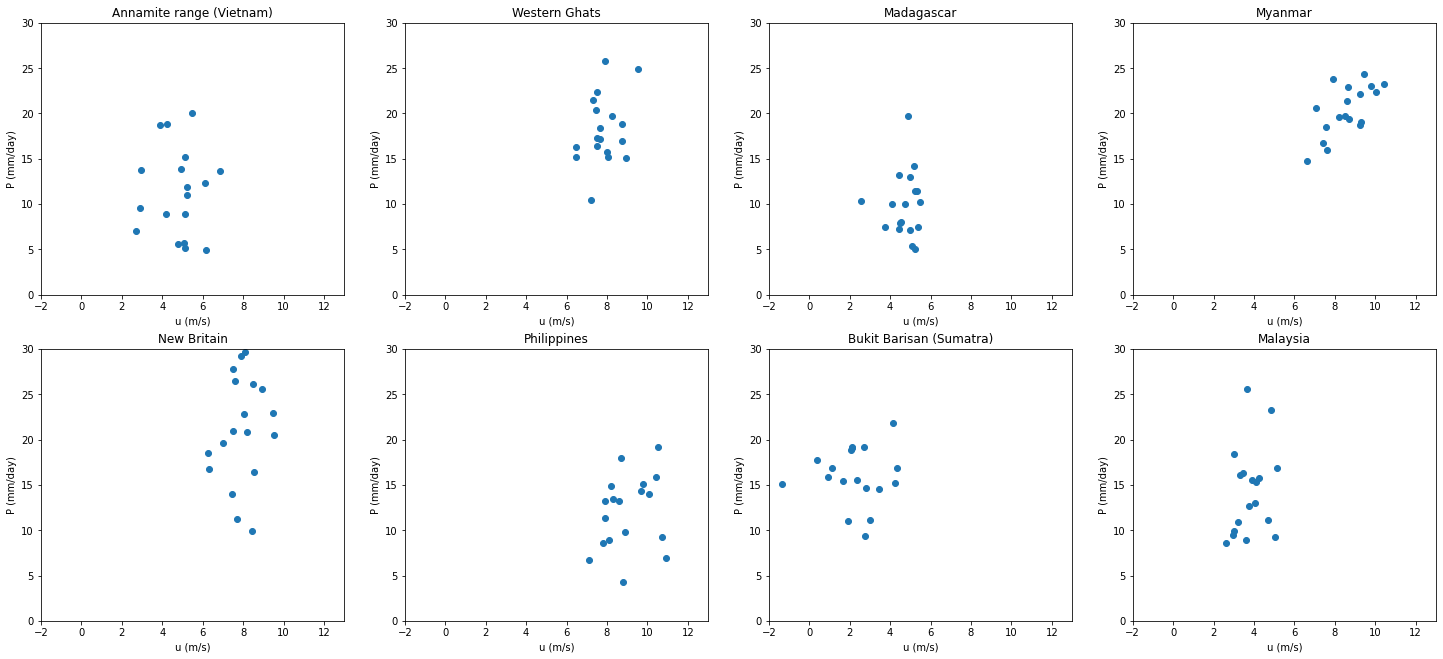

In [62]:
fig,ax = plt.subplots(2,4,figsize=(25,11))
ax=ax.reshape(-1)
for a,name in zip(ax,umeans.keys()):
    a.scatter(np.array(umeans[name]),np.array(prmeans[name]))
    a.set_title(mountains[name][1])
    a.set_xlabel('u (m/s)')
    a.set_ylabel('P (mm/day)')
    a.set_xlim(-2.,13.)
    a.set_ylim(0.,30.)

# Using daily/12-hourly data, focus on Western Ghats

As a first try, we control for u and q at a given height. Then focus on $dq/dz$

## daily

In [17]:
era5100u_daily_ghats = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.sfc.228_246_100u.ll025sc.1998-2013.JJA.ghats.upstreammean.nc')
era5100v_daily_ghats = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.sfc.228_247_100v.ll025sc.1998-2013.JJA.ghats.upstreammean.nc')
trmm_daily_ghats     = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/TRMM/trmm.1998-2013.JJA.ghats.mean.nc')
era5q_daily_ghats = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_133_q.ll025sc.1998-2013.JJA.ghats.upstreammean.nc')


In [18]:
era5crossslope_daily_ghats = crossslopeflow(era5100u_daily_ghats,era5100v_daily_ghats,mountains["ghats"][2])

In [19]:
deltaq = era5q_daily_ghats.sel(level=900.)-era5q_daily_ghats.sel(level=700.)
q900=era5q_daily_ghats.sel(level=900.)
qavg=era5q_daily_ghats.sel(level=slice(700.,900.)).mean('level')

In [20]:
era5q_daily_ghats_above = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_133_q.ll025sc.1998-2013.JJA.ghats.mean.nc')
qavg_above=era5q_daily_ghats_above.sel(level=slice(700.,900.)).mean('level')

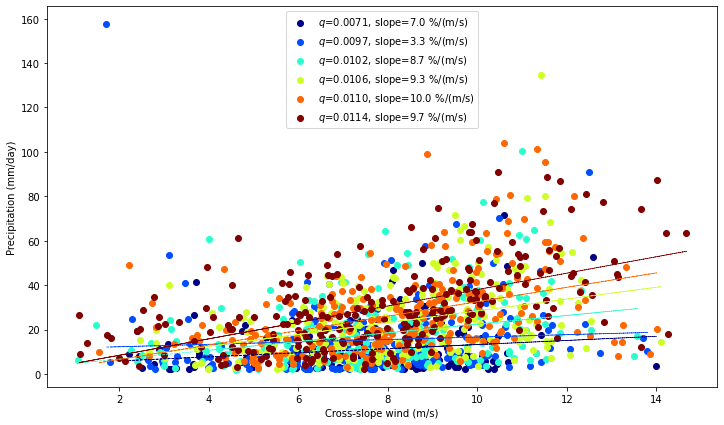

In [82]:
# Binning by humidity
q_measure=qavg
fig,ax = plt.subplots(1,1,figsize=(12,7))
qbins = get_bins(q_measure,6)
colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
for i,q in enumerate(qbins[:-1]):
    condition=(q_measure>=q) & (q_measure<qbins[i+1])& (trmm_daily_ghats>2.)
    us  = era5crossslope_daily_ghats.where(condition,drop=True)
    prs = trmm_daily_ghats.where(condition,drop=True)
    if len(us)!=0:
        reg = linregress(us,prs)
        ax.scatter(us,prs,color=colors[i],label=r'$q$=%.4f, slope=%.1f %%/(m/s)'%(q,100*((11*reg.slope+reg.intercept)/(10*reg.slope+reg.intercept)-1)))
        ax.plot(us,reg.intercept+us*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
    
ax.set_xlabel("Cross-slope wind (m/s)")
ax.set_ylabel("Precipitation (mm/day)")
ax.legend()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


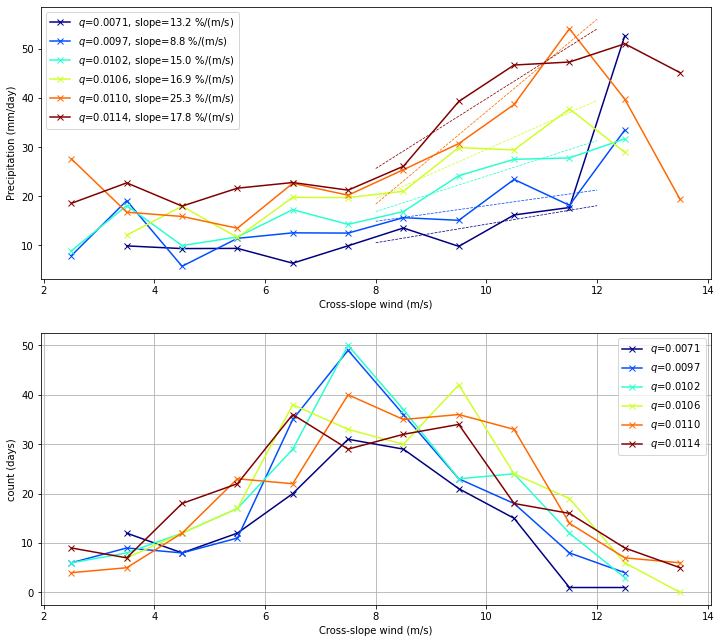

In [21]:
# Binning by humidity
fig,(ax,ax2) = plt.subplots(2,1,figsize=(12,11))
q_measure = qavg
qbins = get_bins(q_measure,6)
ubins=np.arange(1,15,1)
colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
for i,q in enumerate(qbins[:-1]):
    condition=(q_measure>=q) & (q_measure<qbins[i+1])& (trmm_daily_ghats>2.)& (trmm_daily_ghats<150.)
    us  = era5crossslope_daily_ghats.where(condition,drop=True)
    prs = trmm_daily_ghats.where(condition,drop=True)
    if len(us)!=0:
        bin_centers,bin_means = get_binned(us,prs,ubins)
        reg = linregress(bin_centers[(bin_centers>8)&(bin_centers<12)],bin_means[(bin_centers>8)&(bin_centers<12)])
        ax.plot(bin_centers,bin_means,'-x',color=colors[i],label=r'$q$=%.4f, slope=%.1f %%/(m/s)'%(q, 100*((11*reg.slope+reg.intercept)/(10*reg.slope+reg.intercept)-1) ))
        uu = np.linspace(8,12,10)
        ax.plot(uu,reg.intercept+uu*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
        
        bin_centers,count = get_count(us,ubins)
        ax2.plot(bin_centers,count,'-x',color=colors[i],label=r'$q$=%.4f'%(q))    
            

ax.set_xlabel("Cross-slope wind (m/s)")
ax.set_ylabel("Precipitation (mm/day)")
ax.legend()

ax2.set_xlabel("Cross-slope wind (m/s)")
ax2.set_ylabel("count (days)")
ax2.legend()
ax2.grid()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'q in box above ghats')

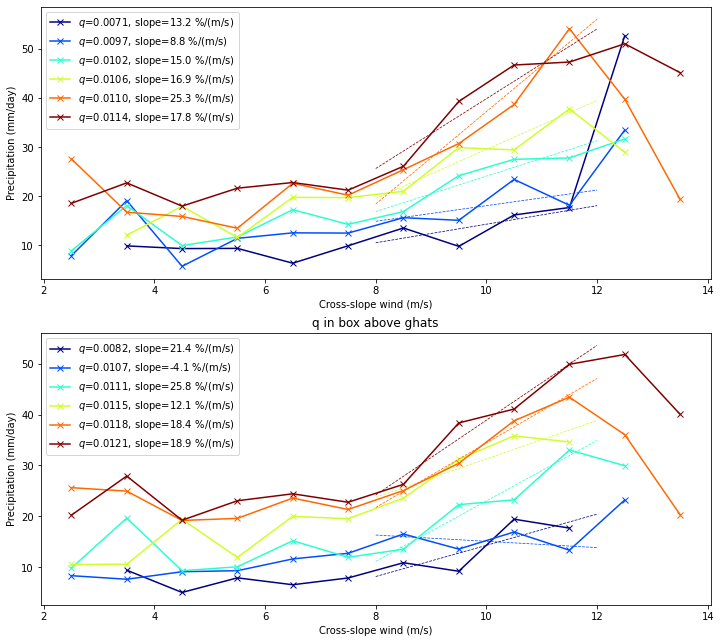

In [22]:
# Binning by humidity
fig,(ax,ax2) = plt.subplots(2,1,figsize=(12,11))
for ax,q_measure in zip((ax,ax2),(qavg,qavg_above)):
    qbins = get_bins(q_measure,6)
    ubins=np.arange(1,15,1)
    colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
    for i,q in enumerate(qbins[:-1]):
        condition=(q_measure>=q) & (q_measure<qbins[i+1])& (trmm_daily_ghats>2.)& (trmm_daily_ghats<150.)
        us  = era5crossslope_daily_ghats.where(condition,drop=True)
        prs = trmm_daily_ghats.where(condition,drop=True)
        if len(us)!=0:
            bin_centers,bin_means = get_binned(us,prs,ubins)
            reg = linregress(bin_centers[(bin_centers>8)&(bin_centers<12)],bin_means[(bin_centers>8)&(bin_centers<12)])
            ax.plot(bin_centers,bin_means,'-x',color=colors[i],label=r'$q$=%.4f, slope=%.1f %%/(m/s)'%(q, 100*((11*reg.slope+reg.intercept)/(10*reg.slope+reg.intercept)-1) ))
            uu = np.linspace(8,12,10)
            ax.plot(uu,reg.intercept+uu*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)  
    
    ax.set_xlabel("Cross-slope wind (m/s)")
    ax.set_ylabel("Precipitation (mm/day)")
    ax.legend()
ax.set_title("q in upstream box")
ax2.set_title("q in box above ghats")
    

## 12-hourly

In [6]:
era5100u_6h_ghats = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.sfc.228_246_100u.ll025sc.1998-2013.JJA.6h.ghats.upstreammean.nc')
era5100v_6h_ghats = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.sfc.228_247_100v.ll025sc.1998-2013.JJA.6h.ghats.upstreammean.nc')
trmm_6h_ghats     = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/TRMM/trmm.1998-2013.JJA.6h.ghats.mean.nc')
era5crossslope_6h_ghats = crossslopeflow(era5100u_6h_ghats,era5100v_6h_ghats,mountains["ghats"][2])

In [7]:
era5q_6h_ghats_above = xr.open_dataarray('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_133_q.ll025sc.1998-2013.JJA.6h.ghats.mean.nc')
qavg_6h_above=era5q_6h_ghats_above.sel(level=slice(700.,900.)).mean('level')

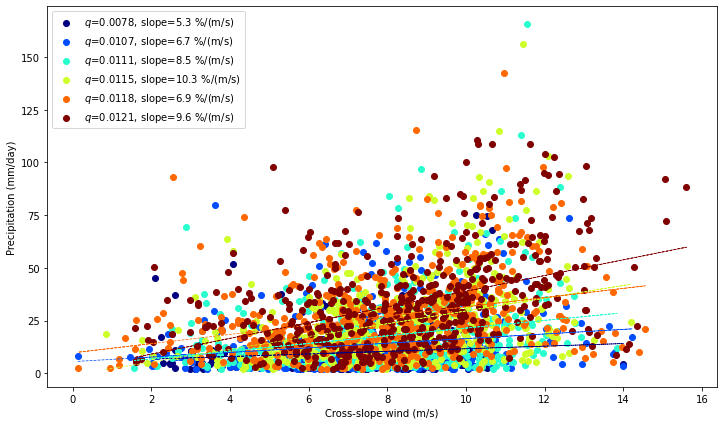

In [14]:
# Binning by humidity
q_measure=qavg_6h_above
fig,ax = plt.subplots(1,1,figsize=(12,7))
qbins = get_bins(q_measure,6)
colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
for i,q in enumerate(qbins[:-1]):
    condition=(q_measure>=q) & (q_measure<qbins[i+1])& (trmm_6h_ghats>2.)& (trmm_6h_ghats<300.)
    us  = era5crossslope_6h_ghats.where(condition,drop=True)
    prs = trmm_6h_ghats.where(condition,drop=True)
    if len(us)!=0:
        reg = linregress(us,prs)
        ax.scatter(us,prs,color=colors[i],label=r'$q$=%.4f, slope=%.1f %%/(m/s)'%(q,100*((11*reg.slope+reg.intercept)/(10*reg.slope+reg.intercept)-1)))
        ax.plot(us,reg.intercept+us*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
    
ax.set_xlabel("Cross-slope wind (m/s)")
ax.set_ylabel("Precipitation (mm/day)")
ax.legend()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


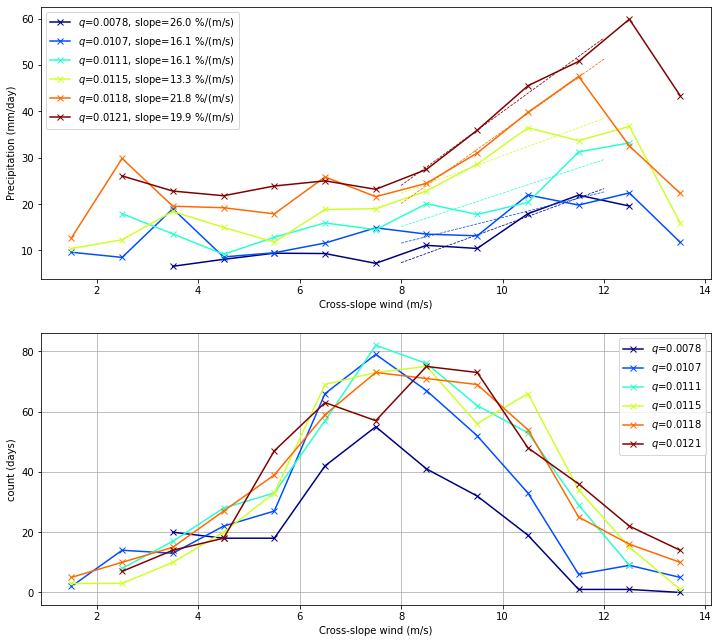

In [15]:
# Binning by humidity
fig,(ax,ax2) = plt.subplots(2,1,figsize=(12,11))
q_measure = qavg_6h_above
qbins = get_bins(q_measure,6)
ubins=np.arange(1,15,1)
colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
for i,q in enumerate(qbins[:-1]):
    condition=(q_measure>=q) & (q_measure<qbins[i+1])& (trmm_6h_ghats>2.)& (trmm_6h_ghats<300.)
    us  = era5crossslope_6h_ghats.where(condition,drop=True)
    prs = trmm_6h_ghats.where(condition,drop=True)
    if len(us)!=0:
        bin_centers,bin_means = get_binned(us,prs,ubins)
        reg = linregress(bin_centers[(bin_centers>8)&(bin_centers<12)],bin_means[(bin_centers>8)&(bin_centers<12)])
        ax.plot(bin_centers,bin_means,'-x',color=colors[i],label=r'$q$=%.4f, slope=%.1f %%/(m/s)'%(q, 100*((11*reg.slope+reg.intercept)/(10*reg.slope+reg.intercept)-1) ))
        uu = np.linspace(8,12,10)
        ax.plot(uu,reg.intercept+uu*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
        
        bin_centers,count = get_count(us,ubins)
        ax2.plot(bin_centers,count,'-x',color=colors[i],label=r'$q$=%.4f'%(q))    
            

ax.set_xlabel("Cross-slope wind (m/s)")
ax.set_ylabel("Precipitation (mm/day)")
ax.legend()

ax2.set_xlabel("Cross-slope wind (m/s)")
ax2.set_ylabel("count (days)")
ax2.legend()
ax2.grid()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


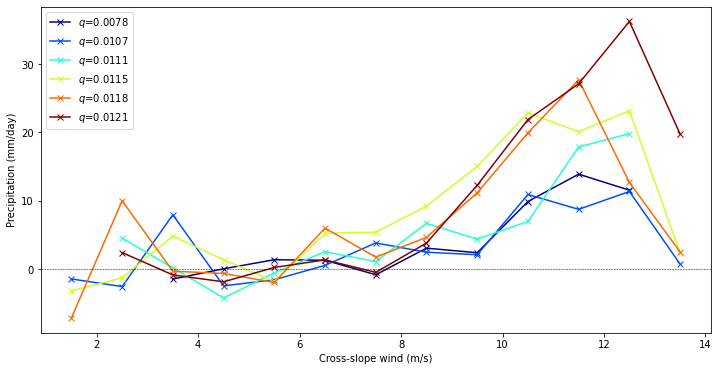

In [27]:
# Binning by humidity
fig,ax = plt.subplots(1,1,figsize=(12,6))
q_measure = qavg_6h_above
qbins = get_bins(q_measure,6)
ubins=np.arange(1,15,1)
colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
for i,q in enumerate(qbins[:-1]):
    condition=(q_measure>=q) & (q_measure<qbins[i+1])& (trmm_6h_ghats>2.)& (trmm_6h_ghats<300.)
    us  = era5crossslope_6h_ghats.where(condition,drop=True)
    prs = trmm_6h_ghats.where(condition,drop=True)
    if len(us)!=0:
        bin_centers,bin_means = get_binned(us,prs,ubins)
        ax.plot(bin_centers,bin_means-bin_means[bin_centers<6].mean(),'-x',color=colors[i],label=r'$q$=%.4f'%q)
ax.axhline(0.,color='k',linestyle='--',linewidth=0.5)
ax.set_xlabel("Cross-slope wind (m/s)")
ax.set_ylabel("Precipitation (mm/day)")
ax.legend()

# Daily data, all regions

In [40]:
%%time
trmmpr_perregion = {name: xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/TRMM/trmm.1998-2013.*.%s.mean.nc'%name)[0]) for name in mountains}
era5crossslope_perregion = {name: crossslopeflow(xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.sfc.228_246_100u.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]),
                                                 xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.sfc.228_247_100v.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]),
                                                 mountains[name][2]) for name in mountains}
era5qavg_perregion = {name: xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_133_q.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]).sel(level=slice(700.,900.)).mean('level') for name in mountains}

CPU times: user 290 ms, sys: 55.5 ms, total: 346 ms
Wall time: 1.47 s


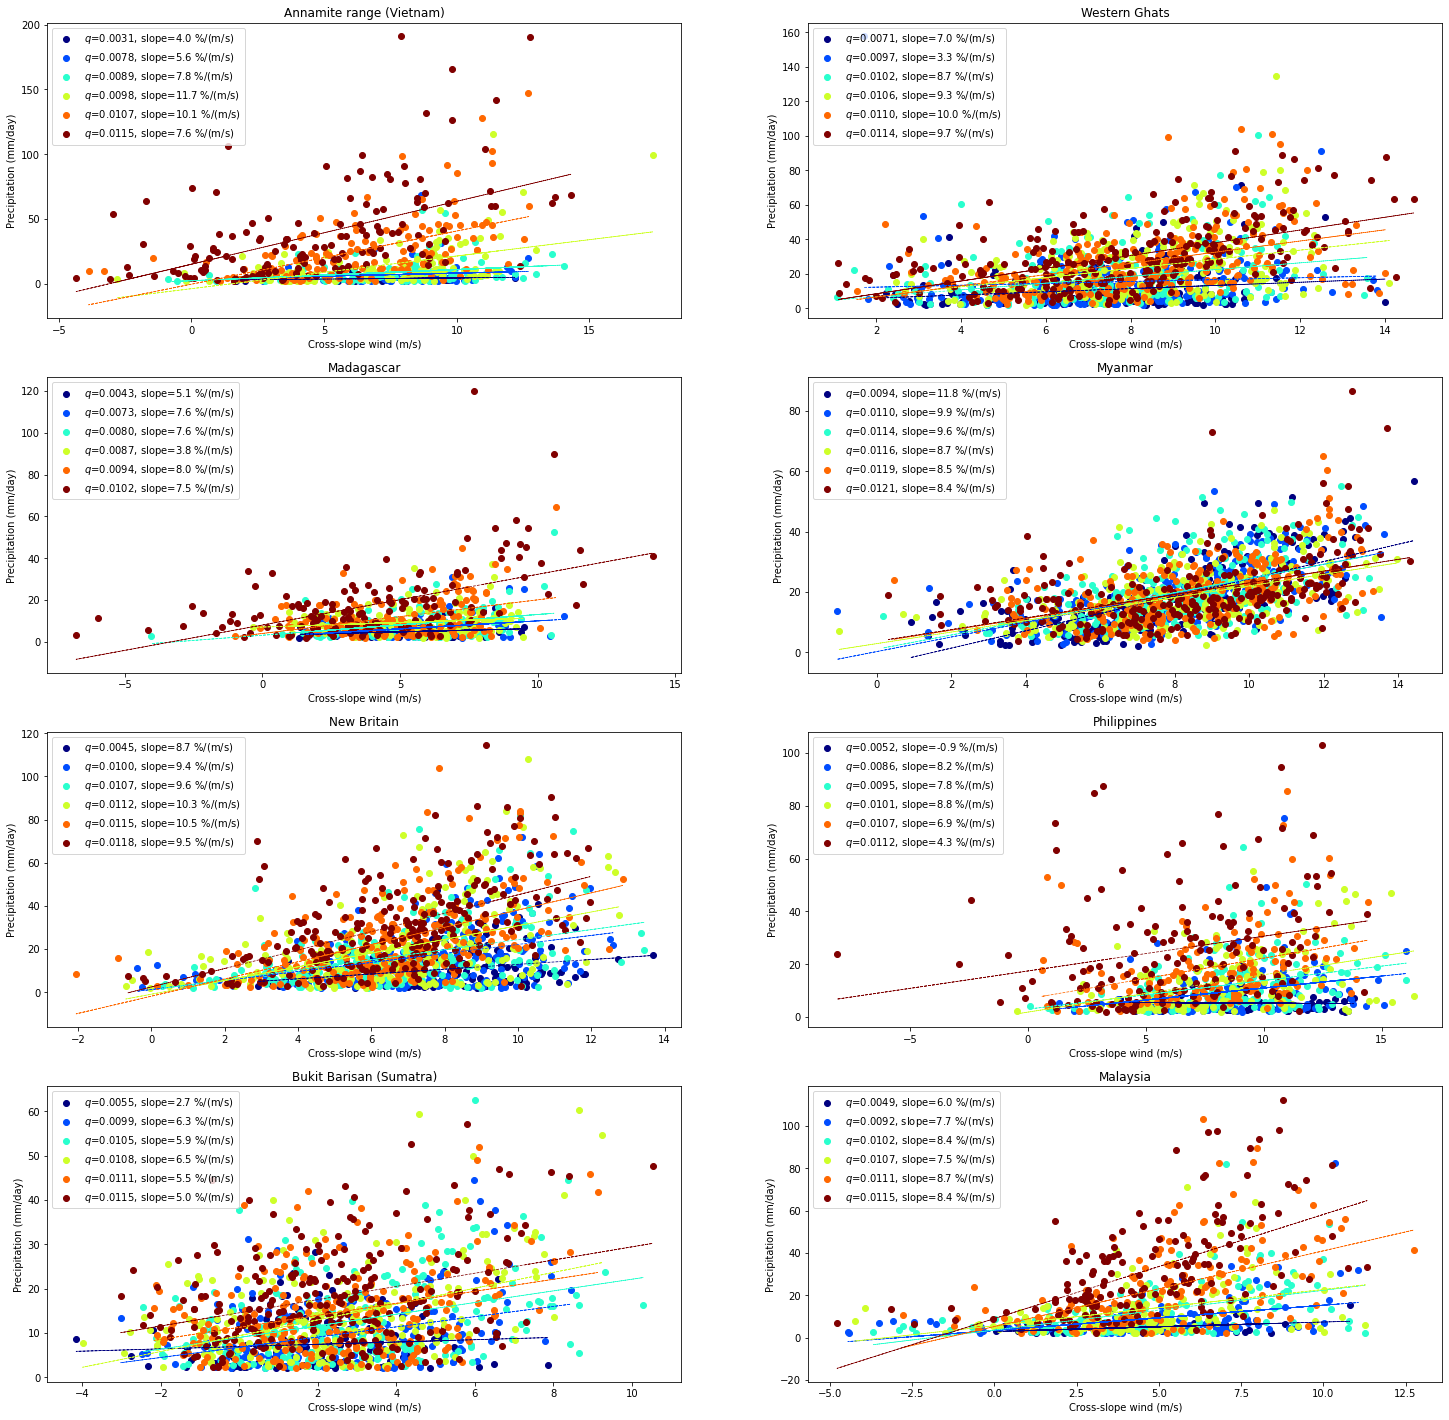

In [10]:
fig,ax = plt.subplots(4,2,figsize=(25,25))
ax = ax.reshape(-1)
for j,name in enumerate(mountains):
    q_measure=era5qavg_perregion[name]
    pr = trmmpr_perregion[name]
    crossslopeu = era5crossslope_perregion[name]
    qbins = get_bins(q_measure,6)
    colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
    
    for i,q in enumerate(qbins[:-1]):
        condition=(q_measure>=q) & (q_measure<qbins[i+1])& (pr>2.)
        us  = crossslopeu.where(condition,drop=True)
        prs = pr.where(condition,drop=True)
        if len(us)!=0:
            reg = linregress(us,prs)
            ax[j].scatter(us,prs,color=colors[i],label=r'$q$=%.4f, slope=%.1f %%/(m/s)'%(q,100*((11*reg.slope+reg.intercept)/(10*reg.slope+reg.intercept)-1)))
            ax[j].plot(us,reg.intercept+us*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
        
    ax[j].set_xlabel("Cross-slope wind (m/s)")
    ax[j].set_ylabel("Precipitation (mm/day)")
    ax[j].legend()
    ax[j].set_title(mountains[name][1])

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice.
  if sys.path[0] == '':
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


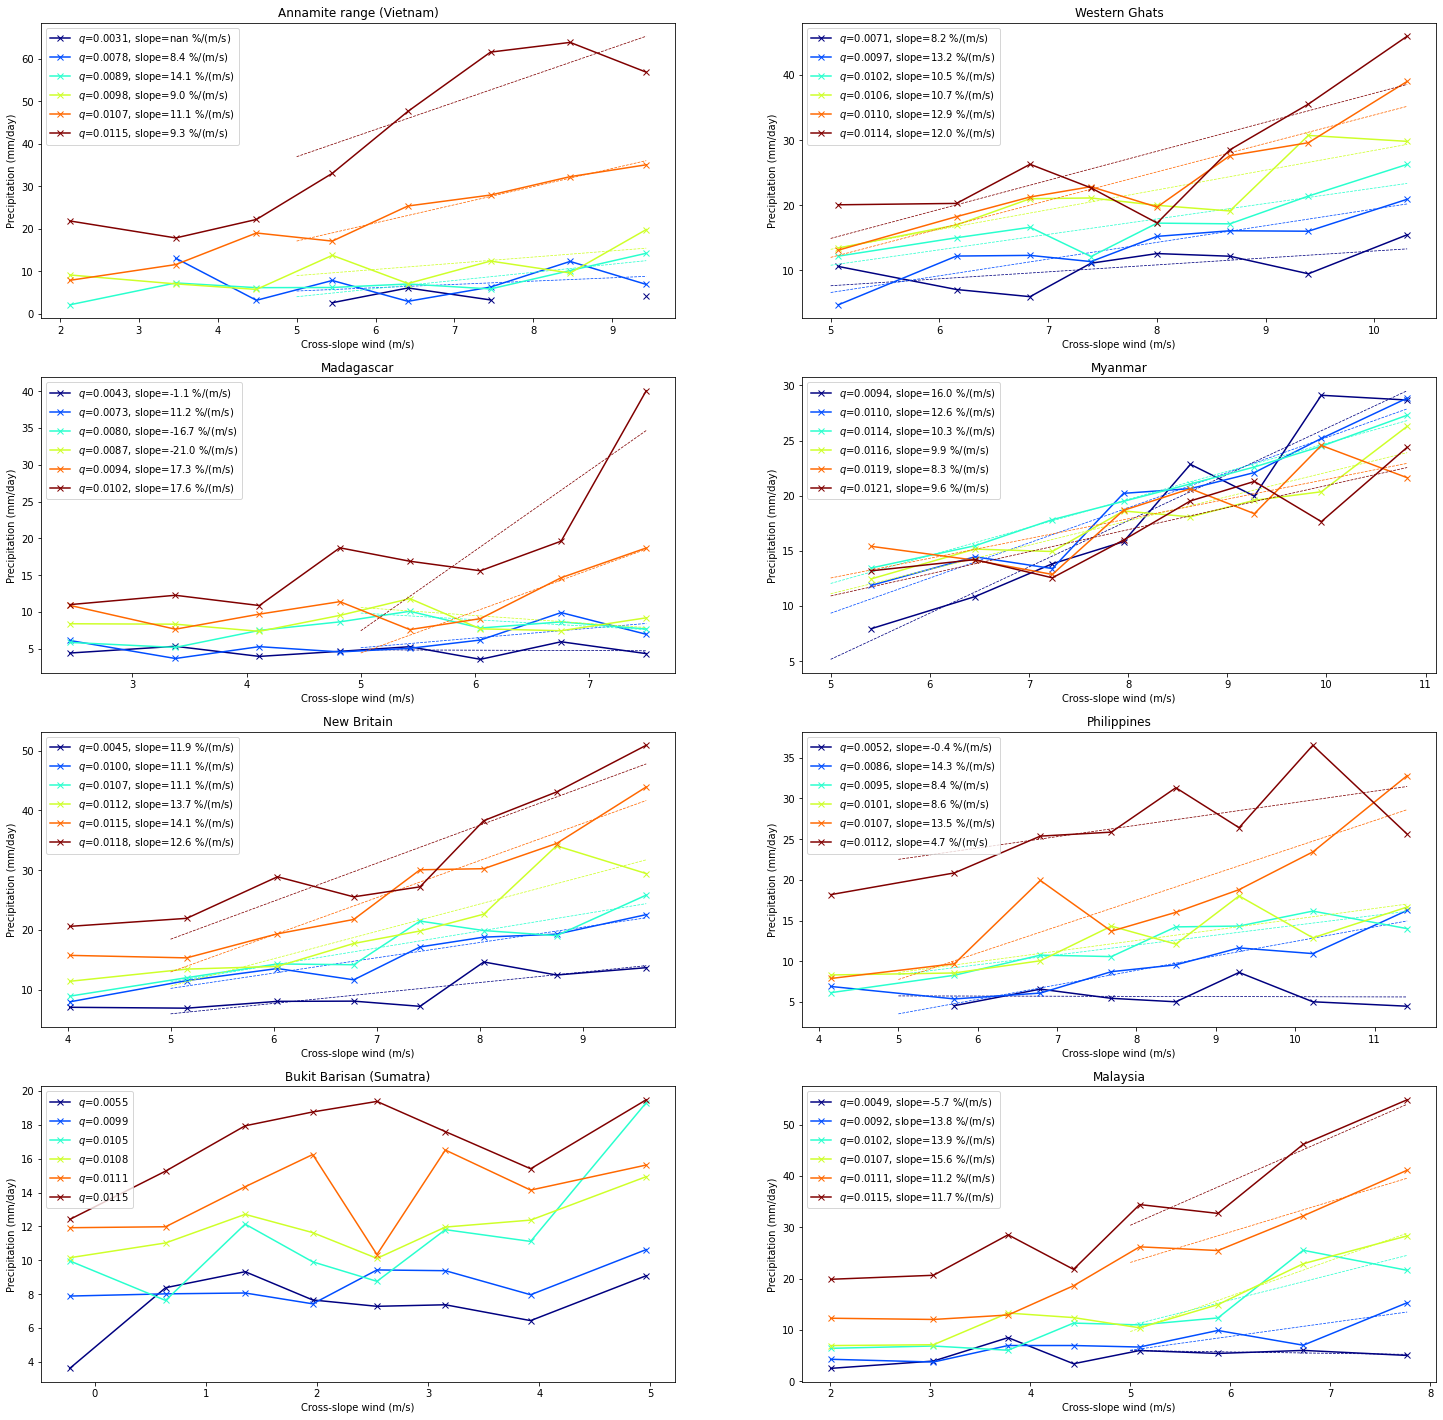

In [28]:
fig,ax = plt.subplots(4,2,figsize=(25,25))
ax = ax.reshape(-1)
for j,name in enumerate(mountains):
    q_measure=era5qavg_perregion[name]
    pr = trmmpr_perregion[name]
    crossslopeu = era5crossslope_perregion[name]
    
    qbins = get_bins(q_measure,6)
    ubins=  np.array(get_bins(crossslopeu,10))#np.arange(1,15,1)
    colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
    
    for i,q in enumerate(qbins[:-1]):
        condition=(q_measure>=q) & (q_measure<qbins[i+1])& (pr>2.) #& (pr<150.)
        us  = crossslopeu.where(condition,drop=True)
        prs = pr.where(condition,drop=True)
        
        if len(us)!=0:
            bin_centers,bin_means = get_binned(us,prs,ubins)
            if ubins[-3]>5:
                reg = linregress(bin_centers[(bin_centers>5)],bin_means[(bin_centers>5)])
                ax[j].plot(bin_centers,bin_means,'-x',color=colors[i],label=r'$q$=%.4f, slope=%.1f %%/(m/s)'%(q, 100*((11*reg.slope+reg.intercept)/(10*reg.slope+reg.intercept)-1) ))
                uu = np.linspace(5,bin_centers[-1],10)
                ax[j].plot(uu,reg.intercept+uu*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
            else:
                ax[j].plot(bin_centers,bin_means,'-x',color=colors[i],label=r'$q$=%.4f'%q)
    ax[j].set_xlabel("Cross-slope wind (m/s)")
    ax[j].set_ylabel("Precipitation (mm/day)")
    ax[j].legend()
    ax[j].set_title(mountains[name][1])

# CAPE & CIN, vertical profile of winds / moisture / static stability

In [17]:
for j,name in enumerate(mountains):
    mask_era5= tilted_rect(era5cape,*precip_boxes[name],reverse=True)
    print("%-12s : CAPE = %.0f J/kg, CIN = %.0f J/kg"%(name,spatial_mean(era5cape.sel(month=mountains[name][3]),box=None,mask=mask_era5),spatial_mean(era5cin.sel(month=mountains[name][3]),box=None,mask=mask_era5)))

vietnam      : CAPE = 384 J/kg, CIN = 96 J/kg
ghats        : CAPE = 1101 J/kg, CIN = 76 J/kg
madagascar   : CAPE = 471 J/kg, CIN = 114 J/kg
myanmar      : CAPE = 975 J/kg, CIN = 77 J/kg
newbritain   : CAPE = 360 J/kg, CIN = 60 J/kg
philippines  : CAPE = 370 J/kg, CIN = 98 J/kg
sumatra      : CAPE = 522 J/kg, CIN = 68 J/kg
malaysia     : CAPE = 598 J/kg, CIN = 73 J/kg


CPU times: user 17.9 s, sys: 12.1 s, total: 30 s
Wall time: 30.1 s


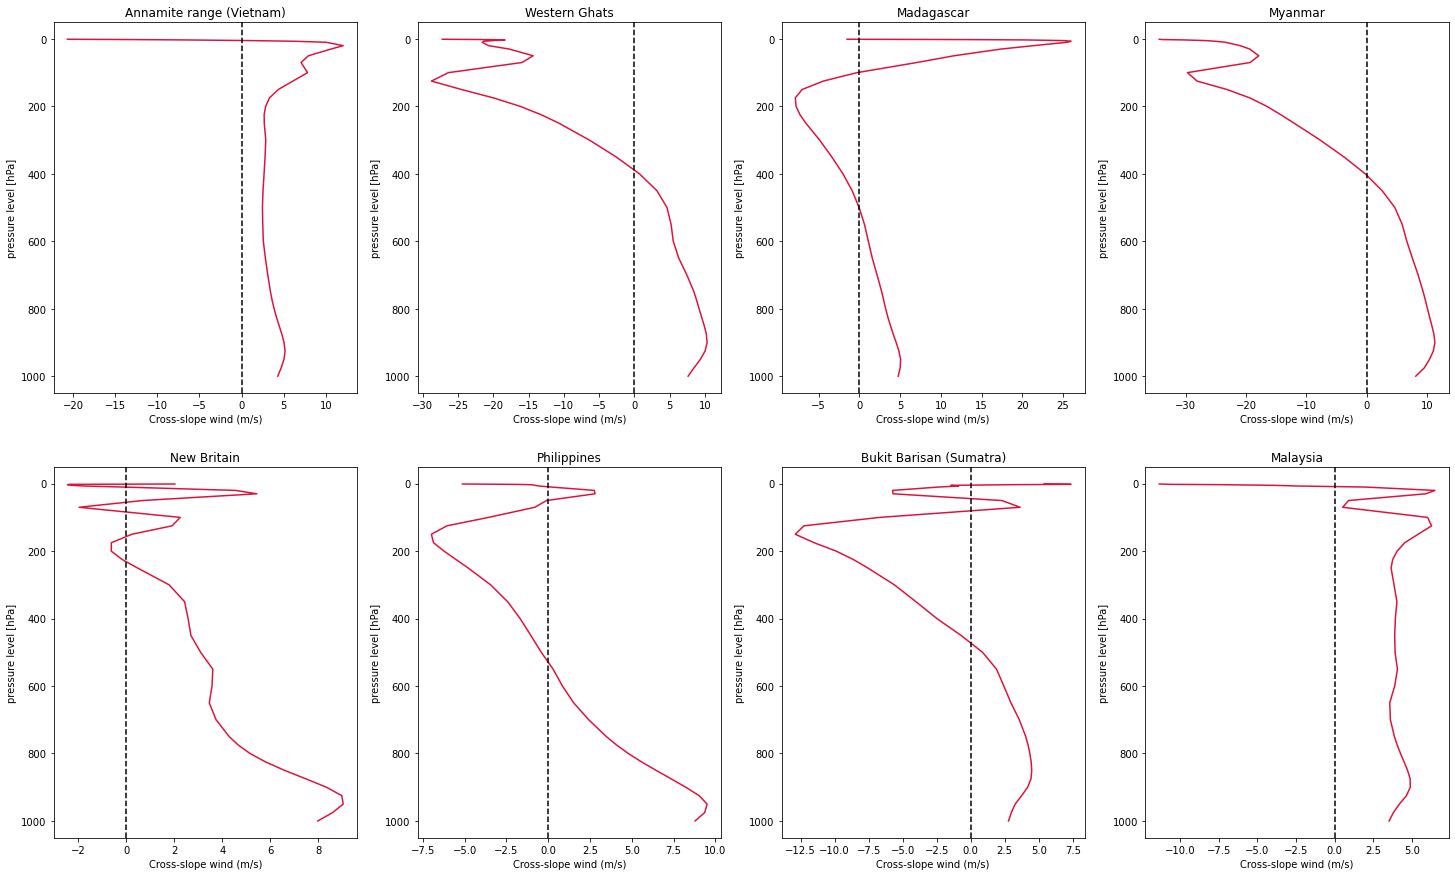

In [39]:
%%time
fig,ax = plt.subplots(2,4,figsize=(25,15))
ax = ax.reshape(-1)
for j,name in enumerate(mountains):
    mask_era5= tilted_rect(era5cape,*precip_boxes[name],reverse=True)
    crossslopeflow( spatial_mean(era5u.sel(month=mountains[name][3]),box=None,mask=mask_era5) , spatial_mean(era5v.sel(month=mountains[name][3]),box=None,mask=mask_era5) , mountains[name][2]).plot(ax=ax[j],y='level',yincrease=False,color='crimson')
    ax[j].set_xlabel("Cross-slope wind (m/s)")
    ax[j].set_title(mountains[name][1])
    ax[j].axvline(0.,color='k',linestyle='--')

In [15]:
def change_coords_pl(w,center=1635,dx=3,plevs_ar=np.array([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,
        82500.,  80000.,  77500.,  75000.,  70000.,  65000.,  60000.,
        55000.,  50000.,  45000.,  40000.,  35000.,  30000.,  25000.,
        22500.,  20000.,  17500.,  15000.,  12500.,  10000.,   7000.,
         5000.,   1000.])):
    plevs=xr.DataArray(plevs_ar,coords={'num_press_levels_stag':np.arange(len(plevs_ar))},dims={'num_press_levels_stag'})
    if 'west_east' in w.dims:
        return w.assign_coords({'distance_from_mtn':(center-w.west_east)*dx,'pressure':plevs/100}).swap_dims({'num_press_levels_stag':'pressure','west_east':'distance_from_mtn'})
    else:
        return w.assign_coords({'pressure':plevs/100}).swap_dims({'num_press_levels_stag':'pressure'})
    

In [12]:
def compute_N(T,pfactor,pname='pressure'):
    """T in K, p in Pa and N in s"""
    g = 9.81; R=287.
    rho = pfactor*T[pname]/R/T
    theta = T*(pfactor*T[pname]/1e5)**(-0.287)
    return np.sqrt(-rho*g*g/theta*theta.differentiate(pname)/pfactor)

In [8]:
wrf_tmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.T_PL.days50-200.nc')
wrf_tmean   = wrf_tmean.where(wrf_tmean >100.)  
wrf_tmean_p = change_coords_pl(wrf_tmean)[1:-4]
wrf_qmean   = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.days50-200.nc')
wrf_qmean = wrf_qmean.where(wrf_qmean >0.)  
wrf_qmean_p = change_coords_pl(wrf_qmean)[1:-4]

In [9]:
wrf_tmean_p_upstream = wrf_tmean_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')
wrf_qmean_p_upstream = wrf_qmean_p.sel(distance_from_mtn=slice(-200,-400)).mean('distance_from_mtn')

In [158]:
#35 min
#%time wrf_qmean_upstream_hourly = hrchannel_p.Q_PL[800:,:,:,1635+200//3:1635+400//3].mean(['south_north','west_east']).load()
#wrf_qmean_upstream_hourly.to_netcdf('/global/cscratch1/sd/qnicolas/wrf.Q_PL.200-400upstream.hourly.nc')
wrf_qmean_upstream_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.3km/diags/wrf.Q_PL.200-400upstream.hourly.nc')
wrf_qmean_p_upstream_hourly = change_coords_pl(wrf_qmean_upstream_hourly)[:,1:-4]
wrf_qmean_p_upstream_daily = wrf_qmean_p_upstream_hourly[400:-1].coarsen(Time=24).mean()
wrf_tmean_upstream_hourly = xr.open_dataarray('/global/cscratch1/sd/qnicolas/wrf.T_PL.200-400upstream.hourly.nc')
wrf_tmean_p_upstream_hourly = change_coords_pl(wrf_tmean_upstream_hourly)[:,1:-4]
wrf_tmean_p_upstream_daily = wrf_tmean_p_upstream_hourly[:-1].coarsen(Time=24).mean()

In [92]:
era5qall_perregion = {name: xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_133_q.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]) for name in mountains}
era5tall_perregion = {name: xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_130_t.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]) for name in mountains}

CPU times: user 7.78 s, sys: 8.88 s, total: 16.7 s
Wall time: 17 s


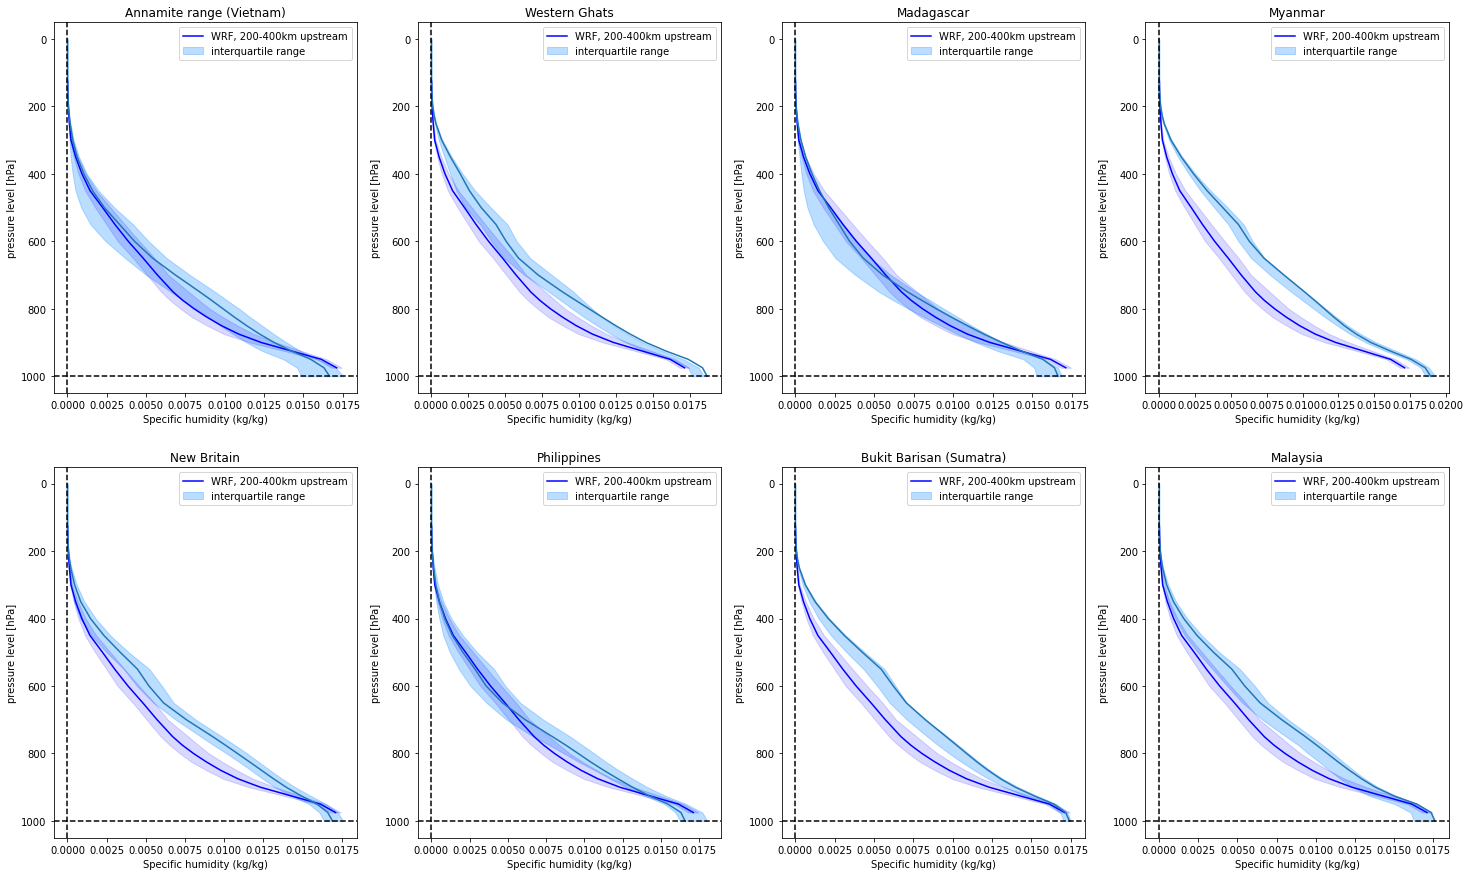

In [91]:
%%time
fig,ax = plt.subplots(2,4,figsize=(25,15))
ax = ax.reshape(-1)
for j,name in enumerate(mountains):
    mask_era5= tilted_rect(era5cape,*precip_boxes[name],reverse=True)
    wrf_qmean_p_upstream.plot(ax=ax[j],y='pressure',yincrease=False,color='b',label='WRF, 200-400km upstream')
    spatial_mean(era5q.sel(month=mountains[name][3]),box=None,mask=mask_era5).plot(ax=ax[j],y='level',yincrease=False)
    ax[j].fill_betweenx(era5qall_perregion[name].level,era5qall_perregion[name].quantile(0.25,dim='time'),era5qall_perregion[name].quantile(0.75,dim='time'),color='dodgerblue',alpha=0.3,label='interquartile range')
    ax[j].fill_betweenx(wrf_qmean_p_upstream_daily.pressure,wrf_qmean_p_upstream_daily.quantile(0.25,dim='Time'),wrf_qmean_p_upstream_daily.quantile(0.75,dim='Time'),color='blue',alpha=0.15)
    
    ax[j].set_xlabel("Specific humidity (kg/kg)")
    ax[j].set_title(mountains[name][1])
    ax[j].axvline(0.,color='k',linestyle='--')
    ax[j].axhline(1000.,color='k',linestyle='--')
    ax[j].legend()


In [18]:
wrf_qmean_p_upstream

<xarray.DataArray 'Q_PL' (pressure: 25)>
array([1.7110378e-02, 1.6137835e-02, 1.4222202e-02, 1.2312285e-02,
       1.0876861e-02, 9.7855143e-03, 8.8656014e-03, 8.0459258e-03,
       7.3270202e-03, 6.7130090e-03, 5.7211928e-03, 4.8124259e-03,
       3.8658460e-03, 3.0180463e-03, 2.2360445e-03, 1.4349323e-03,
       9.2073146e-04, 5.2221306e-04, 2.2380664e-04, 1.2272343e-04,
       8.4326552e-05, 4.9238257e-05, 2.4702284e-05, 1.1583598e-05,
       7.1673448e-06], dtype=float32)
Coordinates:
    num_press_levels_stag  (pressure) int64 1 2 3 4 5 6 7 ... 20 21 22 23 24 25
  * pressure               (pressure) float64 975.0 950.0 925.0 ... 150.0 125.0

CPU times: user 7.5 s, sys: 5.74 s, total: 13.2 s
Wall time: 13.2 s


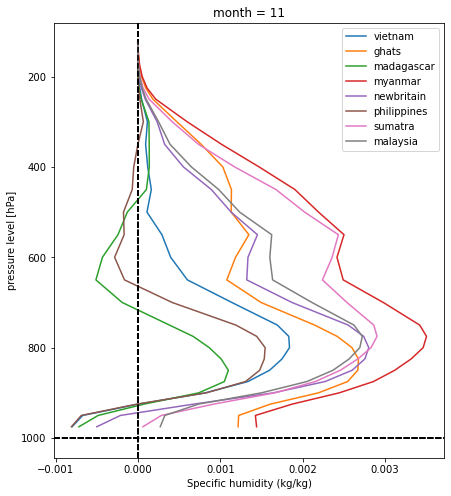

In [22]:
%%time
wrf_qmean_p_upstream_interp=wrf_qmean_p_upstream.rename(pressure='level')[::-1].interp_like(era5q)
fig,ax = plt.subplots(1,1,figsize=(7,8))
for j,name in enumerate(mountains):
    mask_era5= tilted_rect(era5cape,*precip_boxes[name],reverse=True)
    (spatial_mean(era5q.sel(month=mountains[name][3]),box=None,mask=mask_era5)-wrf_qmean_p_upstream_interp).plot(ax=ax,y='level',yincrease=False,label=name)
    
    ax.set_xlabel("Specific humidity (kg/kg)")
    ax.axvline(0.,color='k',linestyle='--')
    ax.axhline(1000.,color='k',linestyle='--')
    ax.legend()


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/

Text(0.5, 0.98, 'Brunt-Väisälä frequency')

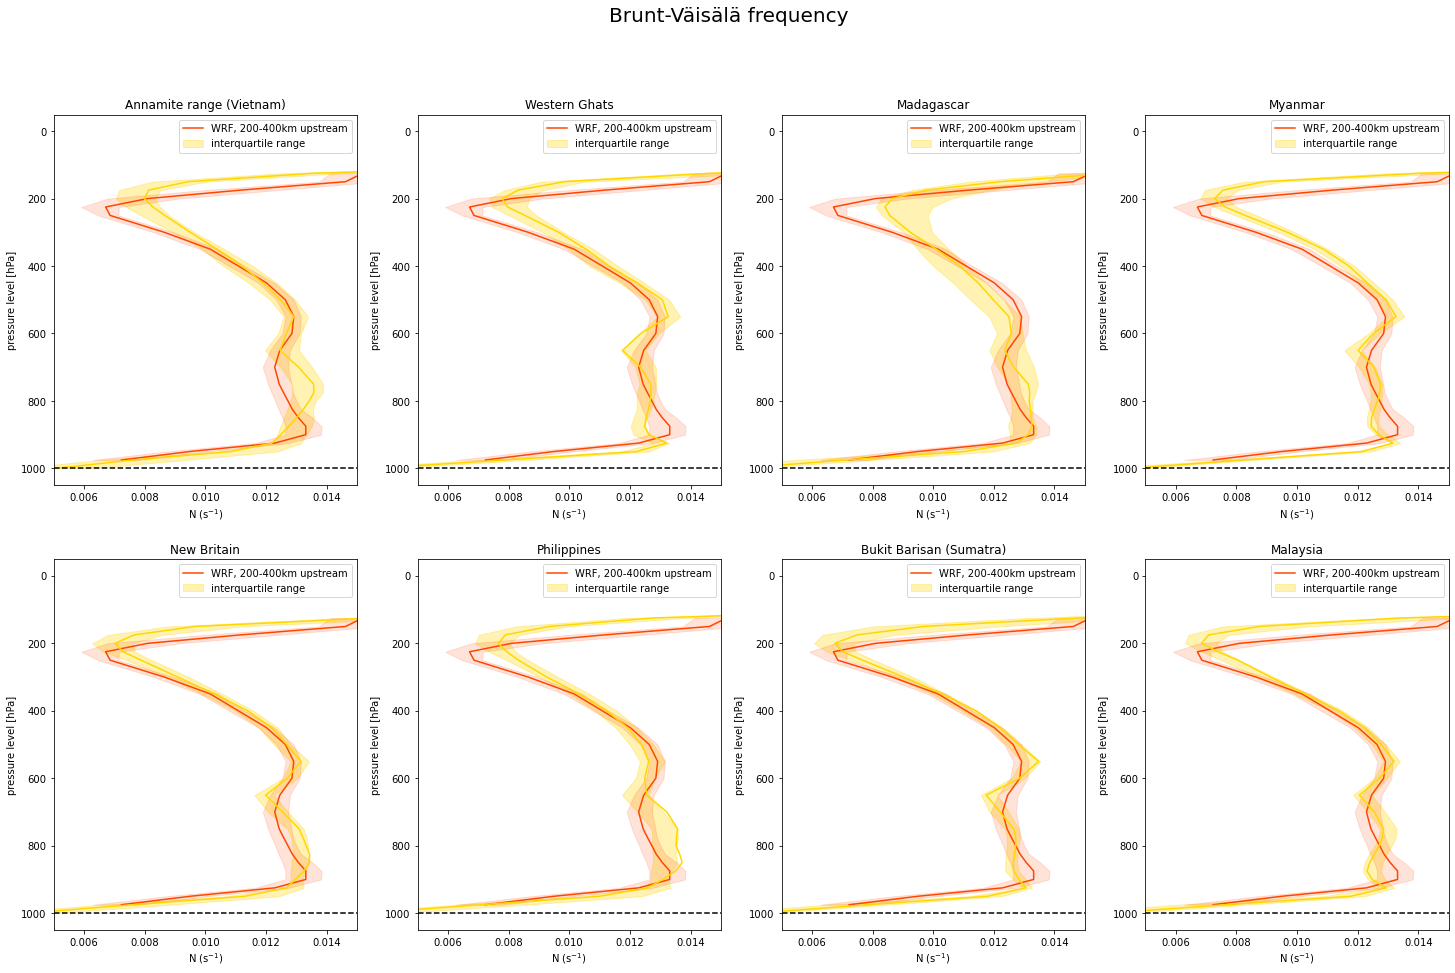

In [162]:
#%%time
fig,ax = plt.subplots(2,4,figsize=(25,15))
ax = ax.reshape(-1)
N_wrf=compute_N(wrf_tmean_p_upstream,100)
N_wrf_daily = compute_N(wrf_tmean_p_upstream_daily,100)
    
for j,name in enumerate(mountains):
    mask_era5= tilted_rect(era5cape,*precip_boxes[name],reverse=True)
    N_wrf.plot(ax=ax[j],y='pressure',yincrease=False,color='orangered',label='WRF, 200-400km upstream')
    t_region = spatial_mean(era5t.sel(month=mountains[name][3]),box=None,mask=mask_era5)
    compute_N(t_region,100,'level').plot(ax=ax[j],y='level',yincrease=False,color='gold')
    N_daily = compute_N(era5tall_perregion[name],100,'level')
    ax[j].fill_betweenx(N_daily.level,N_daily.quantile(0.25,dim='time'),N_daily.quantile(0.75,dim='time'),color='gold',alpha=0.3,label='interquartile range')
    ax[j].fill_betweenx(N_wrf_daily.pressure,N_wrf_daily.quantile(0.25,dim='Time'),N_wrf_daily.quantile(0.75,dim='Time'),color='orangered',alpha=0.15)
    
    
    ax[j].set_xlabel(r"N (s$^{-1})$")
    ax[j].set_title(mountains[name][1])
    ax[j].axvline(0.,color='k',linestyle='--')
    ax[j].axhline(1000.,color='k',linestyle='--')
    ax[j].legend()
    ax[j].set_xlim(0.005,0.015)
fig.suptitle("Brunt-Väisälä frequency",fontsize=20)


vietnam : 0.0003 s^-1
ghats : -0.0002 s^-1
madagascar : 0.0003 s^-1
myanmar : -0.0002 s^-1
newbritain : 0.0003 s^-1
philippines : 0.0007 s^-1
sumatra : -0.0002 s^-1
malaysia : -0.0002 s^-1
CPU times: user 7.71 s, sys: 6.12 s, total: 13.8 s
Wall time: 13.8 s


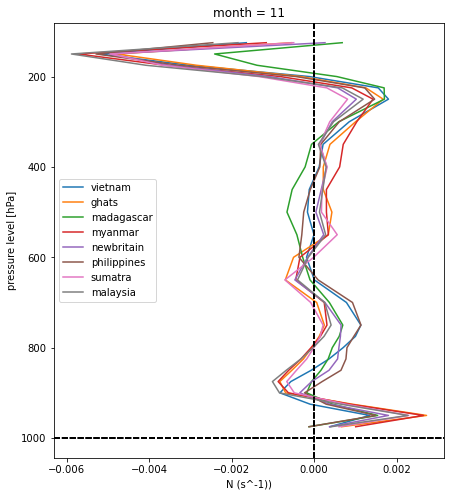

In [28]:
%%time
N_wrf_interp=compute_N(wrf_tmean_p_upstream,100).rename(pressure='level')[::-1].interp_like(era5q)
fig,ax = plt.subplots(1,1,figsize=(7,8))
for j,name in enumerate(mountains):
    mask_era5= tilted_rect(era5cape,*precip_boxes[name],reverse=True)
    t_region = spatial_mean(era5t.sel(month=mountains[name][3]),box=None,mask=mask_era5)
    diff = (compute_N(t_region,100,'level')-N_wrf_interp)
    diff.plot(ax=ax,y='level',yincrease=False,label=name)
    
    print(name+ " : %.4f s^-1"%(diff.sel(level=slice(699,901)).mean()))
    
    
    ax.set_xlabel("N (s^-1))")
    ax.axvline(0.,color='k',linestyle='--')
    ax.axhline(1000.,color='k',linestyle='--')
    ax.legend()


# Multivariate regression

In [15]:
from sklearn.linear_model import LinearRegression

In [21]:
%%time
trmmpr_perregion = {name: xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/TRMM/trmm.1998-2013.*.%s.mean.nc'%name)[0]) for name in mountains}
era5crossslope_perregion = {name: crossslopeflow(xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.sfc.228_246_100u.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]),
                                                 xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.sfc.228_247_100v.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]),
                                                 mountains[name][2]) for name in mountains}
era5qavg_perregion = {name: xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_133_q.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]).sel(level=slice(700.,900.)).mean('level') for name in mountains}
era5Navg_perregion = {name: compute_N(xr.open_dataarray(glob.glob('/global/cscratch1/sd/qnicolas/processedData/ERA5/e5.oper.an.pl.128_130_t.ll025sc.1998-2013.*.%s.upstreammean.nc'%name)[0]),100,'level').sel(level=slice(700.,900.)).mean('level') for name in mountains}

CPU times: user 424 ms, sys: 58.7 ms, total: 483 ms
Wall time: 504 ms


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/

In [130]:
for name in mountains:
    X = np.vstack([np.array(era5crossslope_perregion[name]),
               np.array(era5qavg_perregion[name]),
               np.array(era5Navg_perregion[name])
              ]).transpose()
    y = np.array(trmmpr_perregion[name])
    print("%-12s, R2 = %.3f, sensitivities = "%(name,reg.score(X,y)), reg.coef_*np.std(X,axis=0))


vietnam     , R2 = -0.387, sensitivities =  [ 7.5305947  15.00360243 -4.07294568]
ghats       , R2 = 0.293, sensitivities =  [ 5.42049446  7.30205753 -1.67659745]
madagascar  , R2 = -1.863, sensitivities =  [ 5.68144588 11.63885094 -3.44572267]
myanmar     , R2 = -0.516, sensitivities =  [ 5.60228847  4.69329433 -1.50340918]
newbritain  , R2 = 0.294, sensitivities =  [ 5.81661737  9.45641036 -2.92313221]
philippines , R2 = 0.134, sensitivities =  [ 7.45567309 10.80299886 -3.58197174]
sumatra     , R2 = -0.034, sensitivities =  [ 5.31969059  7.92415423 -1.61901982]
malaysia    , R2 = 0.261, sensitivities =  [ 6.2090081  10.25952172 -2.67446216]


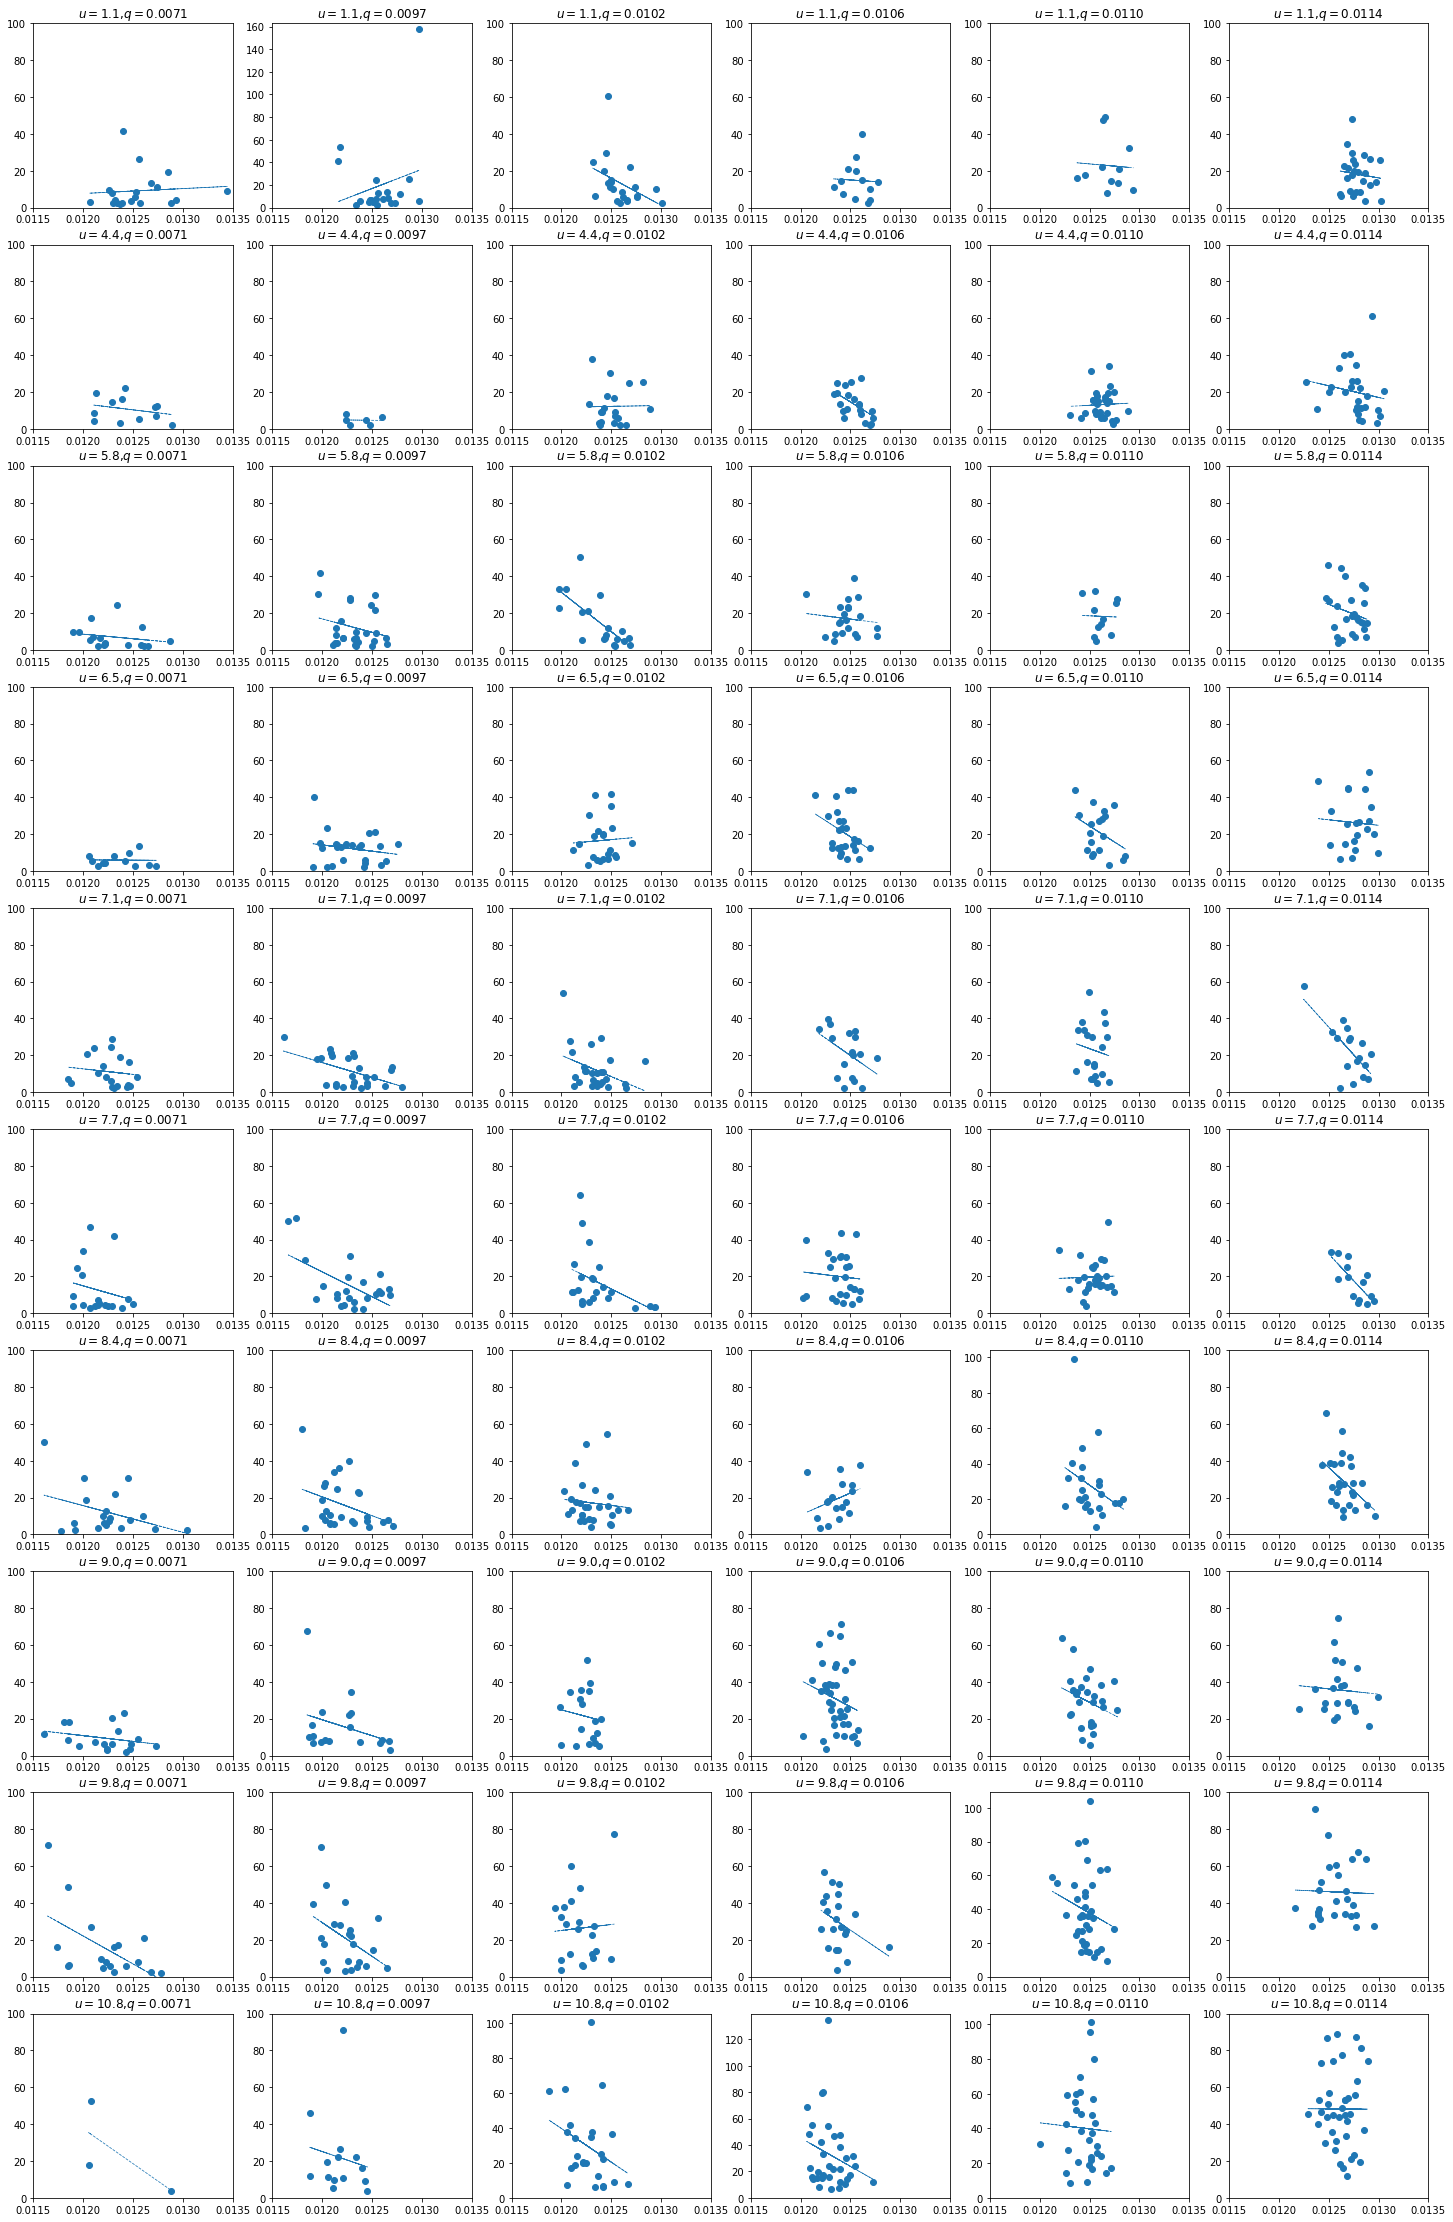

In [142]:
_,ax=plt.subplots(10,6,figsize=(25,40))
for j,name in enumerate(['ghats']):
    q_measure=era5qavg_perregion[name]
    pr = trmmpr_perregion[name]
    N = era5Navg_perregion[name]
    crossslopeu = era5crossslope_perregion[name]
    
    qbins = get_bins(q_measure,6)
    ubins=  np.array(get_bins(crossslopeu,10))#np.arange(1,15,1)

    for i,q in enumerate(qbins[:-1]):
        condition=(q_measure>=q) & (q_measure<qbins[i+1]) & (pr>2.)
        us  = crossslopeu.where(condition,drop=True)
        _,counts=get_count(us,ubins)
        for k,u in enumerate(ubins[:-1]):
            condition=(q_measure>=q) & (q_measure<qbins[i+1]) & (pr>2.) & (crossslopeu>=u) & (crossslopeu<ubins[k+1])
            prs = pr.where(condition,drop=True)
            Ns = N.where(condition,drop=True)
            ax[k,i].scatter(Ns,prs)
            
            reg = linregress(Ns,prs)
            ax[k,i].plot(Ns,reg.intercept+Ns*reg.slope,linestyle='--',linewidth=0.75)
        
            
            ax[k,i].set_title(r'$u=$%.1f,$q=$%.4f'%(u,q))
            ax[k,i].set_xlim(0.0115,0.0135)
            ax[k,i].set_ylim(0.,max(100,max(prs)+5))
        

In [ ]:
print(1)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r

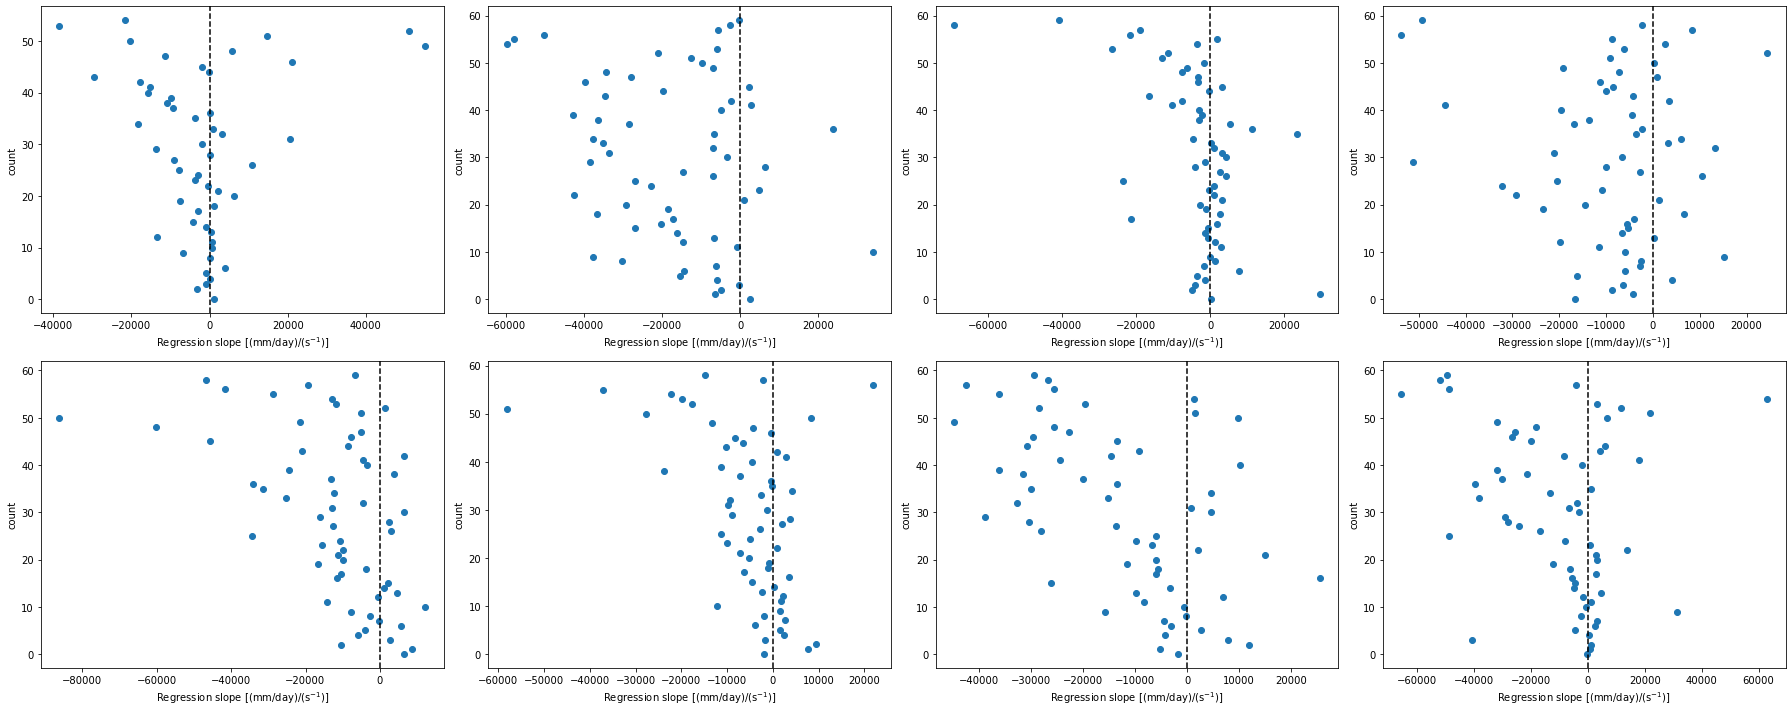

In [22]:
fig,ax = plt.subplots(2,4,figsize=(25,10))
ax = ax.reshape(-1)
for j,name in enumerate(mountains):
    q_measure=era5qavg_perregion[name]
    pr = trmmpr_perregion[name]
    N = era5Navg_perregion[name]
    crossslopeu = era5crossslope_perregion[name]
    
    qbins = get_bins(q_measure,6)
    ubins=  np.array(get_bins(crossslopeu,10))#np.arange(1,15,1)
    slopes=[]
    for i,q in enumerate(qbins[:-1]):
        condition=(q_measure>=q) & (q_measure<qbins[i+1]) & (pr>2.)
        us  = crossslopeu.where(condition,drop=True)
        _,counts=get_count(us,ubins)
        for k,u in enumerate(ubins[:-1]):
            condition=(q_measure>=q) & (q_measure<qbins[i+1]) & (pr>2.) & (crossslopeu>=u) & (crossslopeu<ubins[k+1])
            prs = pr.where(condition,drop=True)
            Ns = N.where(condition,drop=True)
            if len(Ns)>0:
                reg = linregress(Ns,prs)
                slopes.append(reg.slope)
    ax[j].scatter(slopes,np.arange(len(slopes)))
    ax[j].axvline(0.,color='k',linestyle='--')
    ax[j].set_ylabel('count')
    ax[j].set_xlabel(r'Regression slope [(mm/day)/(s$^{-1}$)]')
fig.tight_layout()
        

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:140: RuntimeWarning: invalid value encountered in sqrt
  t = r

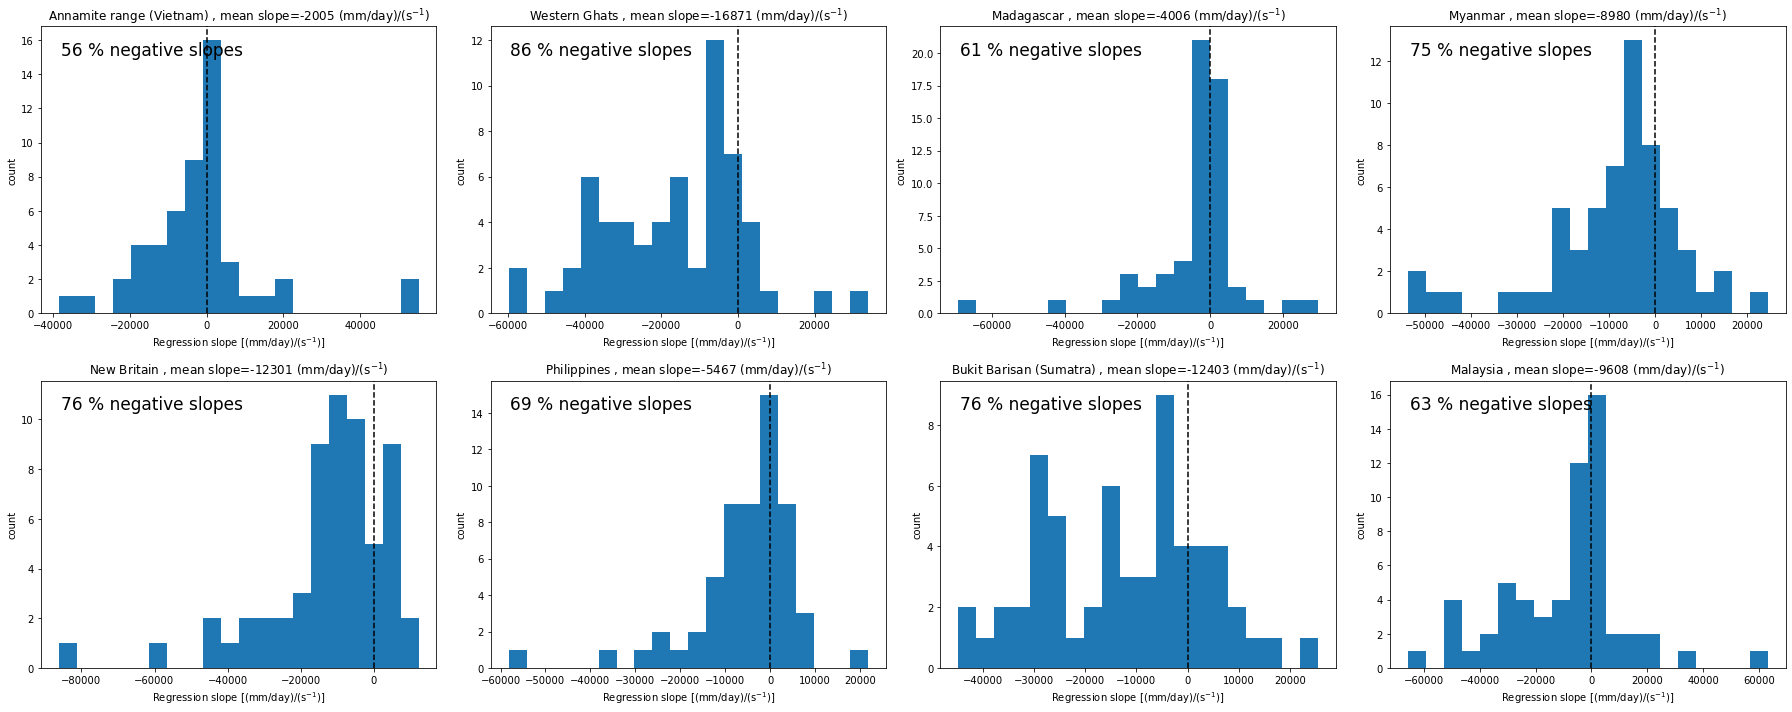

In [24]:
fig,ax = plt.subplots(2,4,figsize=(25,10))
ax = ax.reshape(-1)
for j,name in enumerate(mountains):
    q_measure=era5qavg_perregion[name]
    pr = trmmpr_perregion[name]
    N = era5Navg_perregion[name]
    crossslopeu = era5crossslope_perregion[name]
    
    qbins = get_bins(q_measure,6)
    ubins=  np.array(get_bins(crossslopeu,10))#np.arange(1,15,1)
    slopes=[]
    for i,q in enumerate(qbins[:-1]):
        condition=(q_measure>=q) & (q_measure<qbins[i+1]) & (pr>2.)
        us  = crossslopeu.where(condition,drop=True)
        _,counts=get_count(us,ubins)
        for k,u in enumerate(ubins[:-1]):
            condition=(q_measure>=q) & (q_measure<qbins[i+1]) & (pr>2.) & (crossslopeu>=u) & (crossslopeu<ubins[k+1])
            prs = pr.where(condition,drop=True)
            Ns = N.where(condition,drop=True)
            if len(Ns)>0:
                reg = linregress(Ns,prs)
                slopes.append(reg.slope)
    ax[j].hist(slopes,bins=20)
    ax[j].axvline(0.,color='k',linestyle='--')
    ax[j].set_ylabel('count')
    ax[j].set_xlabel(r'Regression slope [(mm/day)/(s$^{-1}$)]')
    ax[j].text(0.05,0.9,'%i %% negative slopes'%(np.sum(np.array(slopes)<0)/len(slopes)*100),transform=ax[j].transAxes,fontsize=17)
    ax[j].set_title(mountains[name][1]+r" , mean slope=%i (mm/day)/(s$^{-1}$)"%np.nanmean(slopes))
fig.tight_layout()
        

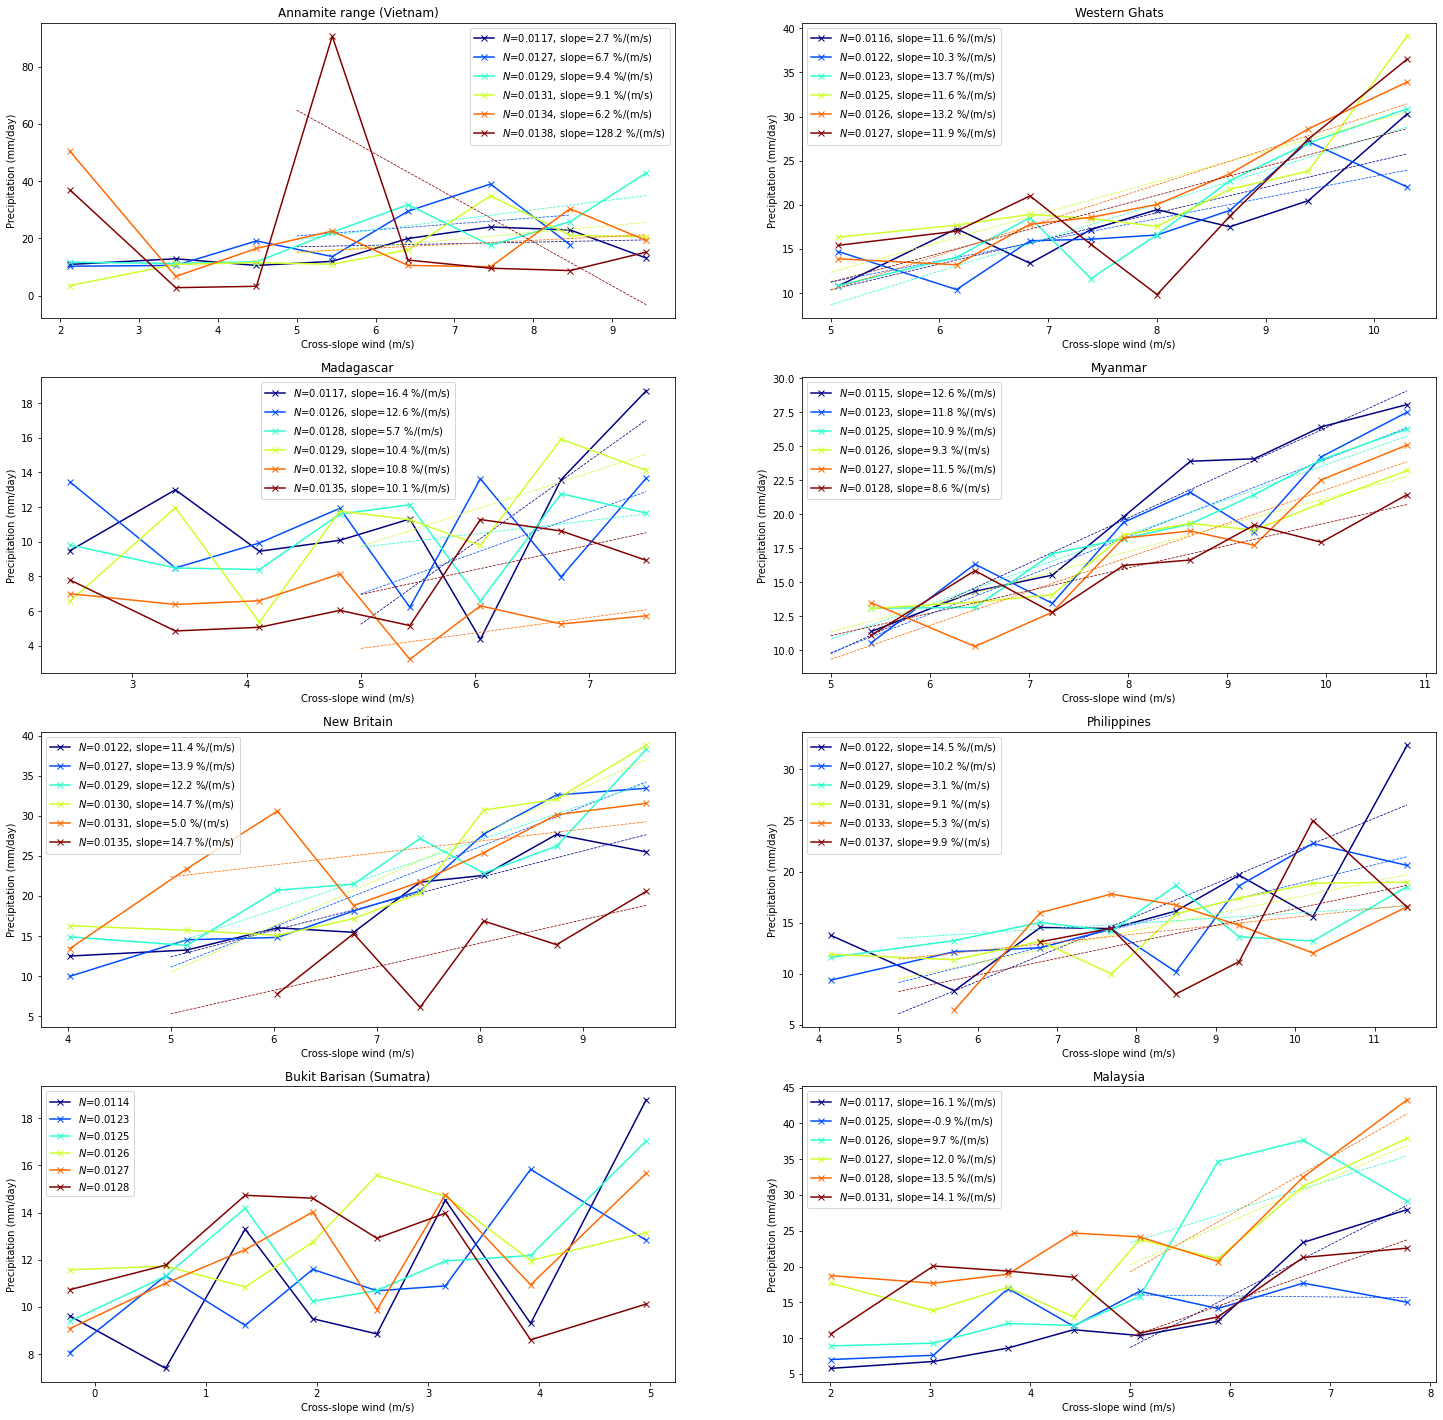

In [27]:
fig,ax = plt.subplots(4,2,figsize=(25,25))
ax = ax.reshape(-1)
for j,name in enumerate(mountains):
    q_measure=era5Navg_perregion[name]
    pr = trmmpr_perregion[name]
    crossslopeu = era5crossslope_perregion[name]
    
    qbins = get_bins(q_measure,6)
    ubins=  np.array(get_bins(crossslopeu,10))#np.arange(1,15,1)
    colors=plt.cm.jet(np.linspace(0,1,len(qbins)-1))
    
    for i,q in enumerate(qbins[:-1]):
        condition=(q_measure>=q) & (q_measure<qbins[i+1])& (pr>2.) #& (pr<150.)
        us  = crossslopeu.where(condition,drop=True)
        prs = pr.where(condition,drop=True)
        
        if len(us)!=0:
            bin_centers,bin_means = get_binned(us,prs,ubins)
            if ubins[-3]>5:
                reg = linregress(bin_centers[(bin_centers>5)],bin_means[(bin_centers>5)])
                ax[j].plot(bin_centers,bin_means,'-x',color=colors[i],label=r'$N$=%.4f, slope=%.1f %%/(m/s)'%(q, 100*((11*reg.slope+reg.intercept)/(10*reg.slope+reg.intercept)-1) ))
                uu = np.linspace(5,bin_centers[-1],10)
                ax[j].plot(uu,reg.intercept+uu*reg.slope,color=colors[i],linestyle='--',linewidth=0.75)
            else:
                ax[j].plot(bin_centers,bin_means,'-x',color=colors[i],label=r'$N$=%.4f'%q)
    ax[j].set_xlabel("Cross-slope wind (m/s)")
    ax[j].set_ylabel("Precipitation (mm/day)")
    ax[j].legend()
    ax[j].set_title(mountains[name][1])